# RMSD Plots

## Align Structures and get RMSD

In [1]:
import pymol
import pandas as pd
import numpy
import urllib
from pathlib import Path
import numpy as np

from benchmark import get_cath
from pathlib import Path
import urllib


import matplotlib as mpl
mpl.rc("savefig", dpi=300)
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (7, 7)
PATH_TO_PDB = Path('/scratch/datasets/pdb/')
from ampal.analyse_protein import (
    sequence_charge,
    sequence_isoelectric_point,
)
import ampal

In [2]:
def calculate_seq_metrics(seq: str):
    """
    Calculates sequence metrics.
    Currently only supports: Charge at pH 7, Isoelectric Point, Molecular Weight
    Parameters
    ----------
    seq: str
        Sequence of residues
    Returns
    -------
    metrics: t.Tuple[float, float, float, float]
        (charge , iso_ph, mw, me)
    """
    charge = sequence_charge(seq)
    iso_ph = sequence_isoelectric_point(seq)
    return charge, iso_ph

def calc_rmsd(model1, model2):
    cmd.delete('all')
    cmd.load(model1)
    cmd.load(model2)
    print(cmd.get_object_list('all'))
    sel1, sel2 = cmd.get_object_list('all')

    # Select only C alphas
    sel1 += ' and name CA'
    sel2 += ' and name CA'
    cmd.align(sel1, sel2, cycles=0, transform=0, object='aln')
    mapping = cmd.get_raw_alignment(
        'aln')  # e.g. [[('prot1', 2530), ('prot2', 2540)], ...]
    RMSD = cmd.align(sel1, sel2)[0]
    return RMSD

def fetch_pdb(
        pdb_code: str,
        output_folder: Path,
        pdb_request_url: str = "https://files.rcsb.org/download/",
        is_pdb: bool = True,
) -> None:
    """
    Downloads a specific pdb file into a specific folder.
    Parameters
    ----------
    pdb_code : str
        Code of the PDB file to be downloaded.
    output_folder : Path
        Output path to save the PDB file.
    pdb_request_url : str
        Base URL to download the PDB files.
    is_pdb:bool=False
        If True, get .pdb, else get biological assembly.
    """
    if is_pdb:
        pdb_code_with_extension = f"{pdb_code[:4]}.pdb"
    else:
        pdb_code_with_extension = f"{pdb_code[:4]}.pdb1"
    print(f'{pdb_code_with_extension} is missing and will be downloaded!')
    urllib.request.urlretrieve(pdb_request_url + pdb_code_with_extension,
                               filename=output_folder / pdb_code_with_extension)
    
def get_all_rmsd(model_name, model_path, pdb_path, pdb_codes):
    pdb_rmsd = []
    pdb_charge = []
    pdb_iso = []
    for pdb_code in pdb_codes:
        baseline_path =  pdb_path / f"{pdb_code[:4]}.pdb1"
        curr_model_path = model_path / f"{model_name}_{pdb_code}A_relaxed_model_3.pdb"
        assert baseline_path.exists(), f"{baseline_path} does not exist"
        if curr_model_path.exists():
            rmsd = calc_rmsd(baseline_path, curr_model_path)
            # Original:
            original_pdb = ampal.load_pdb(baseline_path)
            original_sequence = original_pdb[0].sequences[0]
            ori_charge, ori_iso = calculate_seq_metrics(original_sequence)
            # Designed:
            design_pdb = ampal.load_pdb(curr_model_path)
            print(dir(design_pdb[0]))
            design_sequence = design_pdb[0].sequences
            des_charge, des_iso = calculate_seq_metrics(design_sequence)
            # Calculate MAE:
            mae_iso = abs(ori_iso - des_iso)
            mae_charge = abs(ori_charge - des_charge)
        else:
            print(f"{curr_model_path} does not exist")
            rmsd = np.nan
            mae_iso = np.nan
            mae_charge = np.nan
        pdb_rmsd.append(rmsd)
        pdb_charge.append(mae_charge)
        pdb_iso.append(mae_iso)
    return pdb_rmsd, pdb_charge, pdb_iso

        

pymol.pymol_argv = ['pymol', '-qc']
pymol.finish_launching()
cmd = pymol.cmd


In [3]:
model_names = ['evoEF2', 'rosetta', 'prodconn', 'timed', 'timed_unbalanced', 'timed_deep', 'DenseNet', 'densecpd','timed_rotamer', 'timed_rotamer_deep','TIMED_polar_fix', 'TIMED_charge' ]
path_to_model_structures = Path('/scratch/alphafold/localcolabfold/')
path_to_benchmark_structures = Path('/scratch/timed_dataset/benchmark_pdbs/')
better_names = ['EvoEF2', 'Rosetta', 'ProDCoNN', 'TIMED', 'TIMED_Unbalanced', 'TIMED_Deep', 'DenseNet', 'DenseCPD','TIMED_Rotamer', 'TIMED_Rotamer_Deep','TIMED_Polar', 'TIMED_Charge' ]

Create accuracy file and divide by fold class

In [4]:
cath_location = "/scratch/pdb-compare/sequence-recovery-benchmark/cath-domain-description-file.txt"
cath_df = get_cath.read_data(cath_location)
df = get_cath.filter_with_user_list(cath_df,'/scratch/pdb-compare/sequence-recovery-benchmark/single_chain.txt')
df = get_cath.append_sequence(df, PATH_TO_PDB)

/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [29]:
from copy import copy
for model_name in model_names:
	#model_name = 'skilled-wind-134-timed_hs1000_l2_dp03_weighted'
	path_to_file = Path(f"timed_paper_2023/{model_name}.csv")
	print(model_name)
	print(path_to_file.exists())
	print(path_to_file.with_suffix('.txt').exists())
	# select only monomers
	new_df = copy(df)
	# choose your model
	with open(path_to_file.with_suffix('.txt')) as datasetmap:
	    predictions = get_cath.load_prediction_matrix(new_df,
	                                                  path_to_file.with_suffix(
	                                                      '.txt'), path_to_file)
	accuracy, recall = get_cath.score_each(new_df, predictions, by_fragment=False)
	model_path = path_to_model_structures / model_name
	pdb_rmsd, pdb_charge, pdb_iso = get_all_rmsd(model_name, model_path, path_to_benchmark_structures, list(new_df.PDB.values))
	new_df['accuracy'] = accuracy
	new_df['recall'] = recall
	new_df['rmsd'] = pdb_rmsd
	new_df['charge'] = pdb_charge
	new_df['iso'] = pdb_iso
	new_df.to_csv(f"performance/{model_name}_performance.csv")

evoEF2
True
True
['3e3v', 'evoEF2_3e3vA_relaxed_model_3']
Undo has been disabled. Reason: Memory exceeded
 Selector-Error: Invalid selection name "3e3v".
3e3v and name CA<--


CmdException:  Error: 

## RMSD Plot

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


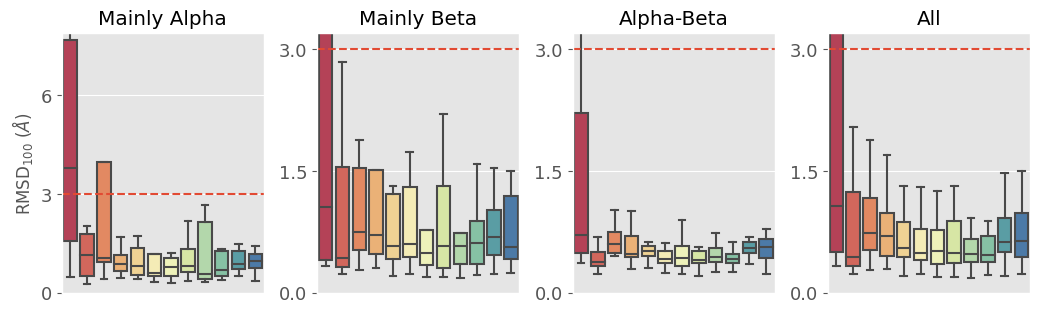

In [14]:
import matplotlib as mpl

mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt

plt.style.use("ggplot")


# plt.rcParams["figure.figsize"] = (10, 5)

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

def set_size(width, fraction=1):
    """ Set aesthetic figure dimensions to avoid scaling in latex.

    Parameters
    ----------
    width: float
            Width in pts
    fraction: float
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5 ** 0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio / 2

    return fig_width_in, fig_height_in


RMSD_100 = True


class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
new_df.sort_values(by="PDB", inplace=True)
pdb_class_map = new_df['class'].to_numpy()
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)

axes = [ax, ax2, ax3, ax4]
for c in range(1,5):
    # the figure and axes
    if c < 4:
        current_map = pdb_class_map == c
    else:
        # Select all
        current_map = pdb_class_map != 0

    data_rmsd = []
    data_recall = []
    data_accuracy = []
    sequences = []

    median = 0
    for i, model_name in enumerate(model_names):
        df = pd.read_csv(f"performance/{model_name}_performance.csv")
        df.sort_values(by="PDB", inplace=True)

        x = df.recall.to_numpy() * 100
        z = df.accuracy.to_numpy() * 100
        y_nan = df.rmsd.to_numpy()
        # Remove NaN
        y = y_nan[~np.isnan(y_nan)]
        x = x[~np.isnan(y_nan)]
        z = z[~np.isnan(y_nan)]
        # Select current class:
        # try:
        y = y[current_map]
        x = x[current_map]
        z = z[current_map]
        seqs = df.sequence.to_numpy()
        seqs = np.array([len(seq) for seq in seqs])
        sequences = seqs[~np.isnan(y_nan)]

        sequences = sequences[current_map]
        assert len(sequences) == len(y)

        # raise ValueError
        # except:
        #     pass
        #print(f"There are {len(x)} structures for class {c} - {class_names[c-1]}")
        if RMSD_100 == True:
            rmsd_100 = []
            for curr_rsmd, curr_len in zip(y, sequences):
                rmsd_100.append(curr_rsmd / (1 + np.log(curr_len/100)))
            data_rmsd.append(np.array(rmsd_100))
        else:
            data_rmsd.append(y)
        data_recall.append(x)
        data_accuracy.append(x)
        if model_name == "evoEF2":
            median = np.median(y)

    SHOW_OUTLIERS = False
    # Do boxplots
    # 1 - RMSD
    sns.boxplot(data=data_rmsd, ax = axes[c-1], showfliers = SHOW_OUTLIERS, palette=sns.color_palette("Spectral", n_colors=len(model_names)))
    axes[c-1].set_title(f'{class_names[c-1]}') #, fontsize=20)
    if RMSD_100:
        ax.set_ylabel('RMSD$_{100}$ ($\AA$)')  # , fontsize=20)
    else:
        ax.set_ylabel('RMSD ($\AA$)') #, fontsize=20)
    axes[c-1].tick_params(axis='x') #, labelsize=18)
    axes[c-1].tick_params(axis='y', labelsize=13)
    axes[c-1].yaxis.set_major_locator(plt.MaxNLocator(3))
    axes[c-1].axes.xaxis.set_visible(False)
    if c-1 == 0:
        axes[c-1].set_ylim(ymin=0, ymax=median+1) #, ymax=np.max(data_rmsd))
    else:
        axes[c-1].set_ylim(ymin=0, ymax=3.2)
    axes[c-1].axhline(3,  ls='--')
    
    # 2 - Macro Recall
    # sns.boxplot(data=data_recall, ax = ax2, showfliers = SHOW_OUTLIERS)
    # xtickNames = plt.setp(ax2, xticklabels=models)
    # plt.setp(xtickNames, rotation=45, fontsize=18)
    # ax2.set_ylabel('Macro-Recall (%)', fontsize=20)
    # ax2.tick_params(axis='x', labelsize=13)
    # ax2.tick_params(axis='y', labelsize=18)
    # ax2.set_ylim(ymin=0)
    #
    #
    # sns.boxplot(data=data_accuracy, ax = ax3, showfliers = SHOW_OUTLIERS)
    # xtickNames = plt.setp(ax3, xticklabels=models)
    # plt.setp(xtickNames, rotation=45, fontsize=18)
    # ax3.set_xlabel('Models', fontsize=20)
    # ax3.set_ylabel('Accuracy (%)', fontsize=20)
    # ax3.tick_params(axis='x', labelsize=13)
    # ax3.tick_params(axis='y', labelsize=18)
    # ax3.set_ylim(ymin=0) #, ymax=np.max(data_accuracy))


    del data_rmsd; del data_accuracy; del data_recall
    
plt.tight_layout()
plt.show()
#plt.savefig(f"boxplot_RMSD_Norm_{RMSD_100}.eps", dpi=300)
plt.close()

## Accuracy

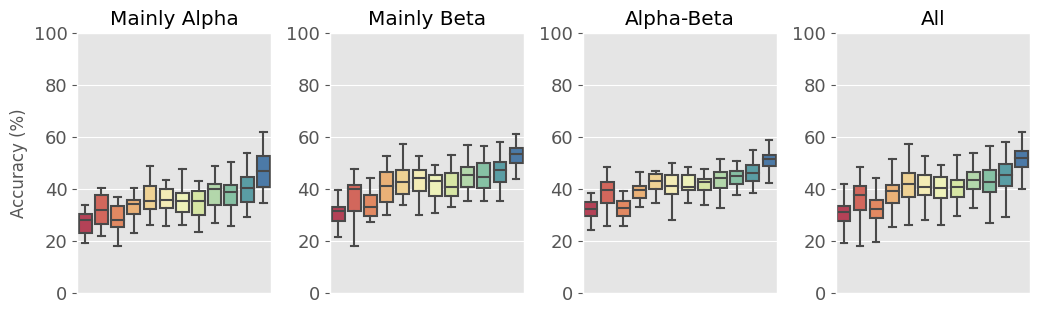

In [11]:
import matplotlib as mpl

mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt

plt.style.use("ggplot")


# plt.rcParams["figure.figsize"] = (10, 5)

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

def set_size(width, fraction=1):
    """ Set aesthetic figure dimensions to avoid scaling in latex.

    Parameters
    ----------
    width: float
            Width in pts
    fraction: float
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5 ** 0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio / 2

    return fig_width_in, fig_height_in


RMSD_100 = True


class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
new_df.sort_values(by="PDB", inplace=True)
pdb_class_map = new_df['class'].to_numpy()
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)

axes = [ax, ax2, ax3, ax4]
for c in range(1,5):
    # the figure and axes
    if c < 4:
        current_map = pdb_class_map == c
    else:
        # Select all
        current_map = pdb_class_map != 0

    data_rmsd = []
    data_recall = []
    data_accuracy = []
    sequences = []

    median = 0
    for i, model_name in enumerate(model_names):
        df = pd.read_csv(f"performance/{model_name}_performance.csv")
        df.sort_values(by="PDB", inplace=True)

        x = df.recall.to_numpy() * 100
        z = df.accuracy.to_numpy() * 100
        y_nan = df.rmsd.to_numpy()
        # Remove NaN
        y = y_nan[~np.isnan(y_nan)]
        x = x[~np.isnan(y_nan)]
        z = z[~np.isnan(y_nan)]
        # Select current class:
        # try:
        y = y[current_map]
        x = x[current_map]
        z = z[current_map]
        seqs = df.sequence.to_numpy()
        seqs = np.array([len(seq) for seq in seqs])
        sequences = seqs[~np.isnan(y_nan)]

        sequences = sequences[current_map]
        assert len(sequences) == len(y)

        # raise ValueError
        # except:
        #     pass
        #print(f"There are {len(x)} structures for class {c} - {class_names[c-1]}")
        if RMSD_100 == True:
            rmsd_100 = []
            for curr_rsmd, curr_len in zip(y, sequences):
                rmsd_100.append(curr_rsmd / (1 + np.log(curr_len/100)))
            data_rmsd.append(np.array(rmsd_100))
        else:
            data_rmsd.append(y)
        data_recall.append(x)
        data_accuracy.append(z)
        if model_name == "evoEF2":
            median = np.median(y)

    SHOW_OUTLIERS = False
    # Do boxplots
    # 1 - RMSD
    sns.boxplot(data=data_accuracy, ax = axes[c-1], showfliers = SHOW_OUTLIERS, palette=sns.color_palette("Spectral", n_colors=len(model_names)))
    axes[c-1].set_title(f'{class_names[c-1]}') #, fontsize=20)
    if RMSD_100:
        ax.set_ylabel('Accuracy (%)')  # , fontsize=20)
    else:
        ax.set_ylabel('RMSD ($\AA$)') #, fontsize=20)
    axes[c-1].tick_params(axis='x') #, labelsize=18)
    axes[c-1].tick_params(axis='y', labelsize=13)
    axes[c-1].yaxis.set_major_locator(plt.MaxNLocator(5))
    axes[c-1].axes.xaxis.set_visible(False)
    # if c-1 == 0:
    #     axes[c-1].set_ylim(ymin=0, ymax=median+1) #, ymax=np.max(data_rmsd))
    # else:
    axes[c-1].set_ylim(ymin=0, ymax=100)
    #axes[c-1].axhline(3,  ls='--')
    
    # 2 - Macro Recall
    # sns.boxplot(data=data_recall, ax = ax2, showfliers = SHOW_OUTLIERS)
    # xtickNames = plt.setp(ax2, xticklabels=models)
    # plt.setp(xtickNames, rotation=45, fontsize=18)
    # ax2.set_ylabel('Macro-Recall (%)', fontsize=20)
    # ax2.tick_params(axis='x', labelsize=13)
    # ax2.tick_params(axis='y', labelsize=18)
    # ax2.set_ylim(ymin=0)
    #
    #
    # sns.boxplot(data=data_accuracy, ax = ax3, showfliers = SHOW_OUTLIERS)
    # xtickNames = plt.setp(ax3, xticklabels=models)
    # plt.setp(xtickNames, rotation=45, fontsize=18)
    # ax3.set_xlabel('Models', fontsize=20)
    # ax3.set_ylabel('Accuracy (%)', fontsize=20)
    # ax3.tick_params(axis='x', labelsize=13)
    # ax3.tick_params(axis='y', labelsize=18)
    # ax3.set_ylim(ymin=0) #, ymax=np.max(data_accuracy))


    del data_rmsd; del data_accuracy; del data_recall
    
plt.tight_layout()
plt.show()
#plt.savefig(f"boxplot_RMSD_Norm_{RMSD_100}.eps", dpi=300)
plt.close()

## Macro-Recall

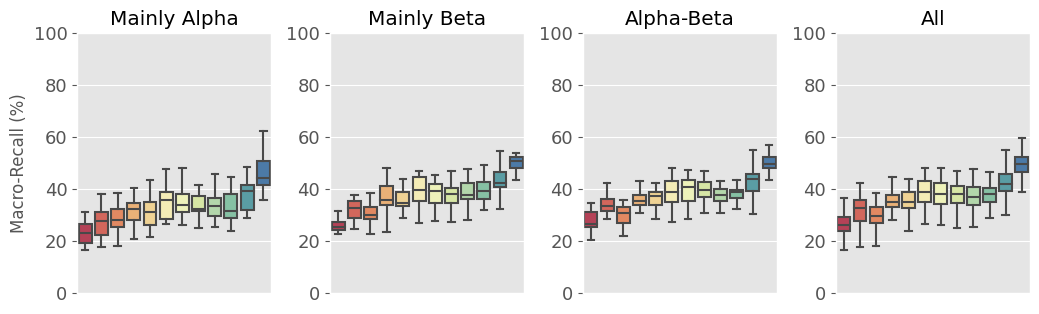

In [12]:
import matplotlib as mpl

mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt

plt.style.use("ggplot")


# plt.rcParams["figure.figsize"] = (10, 5)

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

def set_size(width, fraction=1):
    """ Set aesthetic figure dimensions to avoid scaling in latex.

    Parameters
    ----------
    width: float
            Width in pts
    fraction: float
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5 ** 0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio / 2

    return fig_width_in, fig_height_in


RMSD_100 = True


class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
new_df.sort_values(by="PDB", inplace=True)
pdb_class_map = new_df['class'].to_numpy()
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)

axes = [ax, ax2, ax3, ax4]
for c in range(1,5):
    # the figure and axes
    if c < 4:
        current_map = pdb_class_map == c
    else:
        # Select all
        current_map = pdb_class_map != 0

    data_rmsd = []
    data_recall = []
    data_accuracy = []
    sequences = []

    median = 0
    for i, model_name in enumerate(model_names):
        df = pd.read_csv(f"performance/{model_name}_performance.csv")
        df.sort_values(by="PDB", inplace=True)

        x = df.recall.to_numpy() * 100
        z = df.accuracy.to_numpy() * 100
        y_nan = df.rmsd.to_numpy()
        # Remove NaN
        y = y_nan[~np.isnan(y_nan)]
        x = x[~np.isnan(y_nan)]
        z = z[~np.isnan(y_nan)]
        # Select current class:
        # try:
        y = y[current_map]
        x = x[current_map]
        z = z[current_map]
        seqs = df.sequence.to_numpy()
        seqs = np.array([len(seq) for seq in seqs])
        sequences = seqs[~np.isnan(y_nan)]

        sequences = sequences[current_map]
        assert len(sequences) == len(y)

        # raise ValueError
        # except:
        #     pass
        #print(f"There are {len(x)} structures for class {c} - {class_names[c-1]}")
        if RMSD_100 == True:
            rmsd_100 = []
            for curr_rsmd, curr_len in zip(y, sequences):
                rmsd_100.append(curr_rsmd / (1 + np.log(curr_len/100)))
            data_rmsd.append(np.array(rmsd_100))
        else:
            data_rmsd.append(y)
        data_recall.append(x)
        data_accuracy.append(z)
        if model_name == "evoEF2":
            median = np.median(y)

    SHOW_OUTLIERS = False
    # Do boxplots
    # 1 - RMSD
    sns.boxplot(data=data_recall, ax = axes[c-1], showfliers = SHOW_OUTLIERS, palette=sns.color_palette("Spectral", n_colors=len(model_names)))
    axes[c-1].set_title(f'{class_names[c-1]}') #, fontsize=20)
    if RMSD_100:
        ax.set_ylabel('Macro-Recall (%)')  # , fontsize=20)
    else:
        ax.set_ylabel('RMSD ($\AA$)') #, fontsize=20)
    axes[c-1].tick_params(axis='x') #, labelsize=18)
    axes[c-1].tick_params(axis='y', labelsize=13)
    axes[c-1].yaxis.set_major_locator(plt.MaxNLocator(5))
    axes[c-1].axes.xaxis.set_visible(False)
    # if c-1 == 0:
    #     axes[c-1].set_ylim(ymin=0, ymax=median+1) #, ymax=np.max(data_rmsd))
    # else:
    axes[c-1].set_ylim(ymin=0, ymax=100)
    #axes[c-1].axhline(3,  ls='--')
    
    # 2 - Macro Recall
    # sns.boxplot(data=data_recall, ax = ax2, showfliers = SHOW_OUTLIERS)
    # xtickNames = plt.setp(ax2, xticklabels=models)
    # plt.setp(xtickNames, rotation=45, fontsize=18)
    # ax2.set_ylabel('Macro-Recall (%)', fontsize=20)
    # ax2.tick_params(axis='x', labelsize=13)
    # ax2.tick_params(axis='y', labelsize=18)
    # ax2.set_ylim(ymin=0)
    #
    #
    # sns.boxplot(data=data_accuracy, ax = ax3, showfliers = SHOW_OUTLIERS)
    # xtickNames = plt.setp(ax3, xticklabels=models)
    # plt.setp(xtickNames, rotation=45, fontsize=18)
    # ax3.set_xlabel('Models', fontsize=20)
    # ax3.set_ylabel('Accuracy (%)', fontsize=20)
    # ax3.tick_params(axis='x', labelsize=13)
    # ax3.tick_params(axis='y', labelsize=18)
    # ax3.set_ylim(ymin=0) #, ymax=np.max(data_accuracy))


    del data_rmsd; del data_accuracy; del data_recall
    
plt.tight_layout()
plt.show()
#plt.savefig(f"boxplot_RMSD_Norm_{RMSD_100}.eps", dpi=300)
plt.close()

## Charge

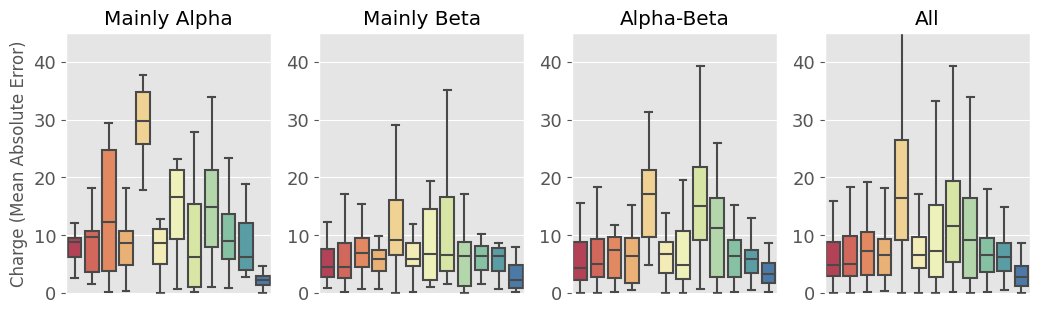

In [28]:
import matplotlib as mpl

mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt

plt.style.use("ggplot")


# plt.rcParams["figure.figsize"] = (10, 5)

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

def set_size(width, fraction=1):
    """ Set aesthetic figure dimensions to avoid scaling in latex.

    Parameters
    ----------
    width: float
            Width in pts
    fraction: float
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5 ** 0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio / 2

    return fig_width_in, fig_height_in


RMSD_100 = True


class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
new_df.sort_values(by="PDB", inplace=True)
pdb_class_map = new_df['class'].to_numpy()
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)

axes = [ax, ax2, ax3, ax4]
for c in range(1,5):
    # the figure and axes
    if c < 4:
        current_map = pdb_class_map == c
    else:
        # Select all
        current_map = pdb_class_map != 0

    data_rmsd = []
    data_charge = []
    data_accuracy = []
    sequences = []
    data_recall = []

    median = 0
    for i, model_name in enumerate(model_names):
        df = pd.read_csv(f"performance/{model_name}_performance.csv")
        df.sort_values(by="PDB", inplace=True)

        x = df.charge.to_numpy()
        z = df.accuracy.to_numpy() * 100
        y_nan = df.rmsd.to_numpy()
        # Remove NaN
        y = y_nan[~np.isnan(y_nan)]
        x = x[~np.isnan(y_nan)]
        z = z[~np.isnan(y_nan)]
        # Select current class:
        # try:
        y = y[current_map]
        x = x[current_map]
        z = z[current_map]
        seqs = df.sequence.to_numpy()
        seqs = np.array([len(seq) for seq in seqs])
        sequences = seqs[~np.isnan(y_nan)]

        sequences = sequences[current_map]
        assert len(sequences) == len(y)

        # raise ValueError
        # except:
        #     pass
        #print(f"There are {len(x)} structures for class {c} - {class_names[c-1]}")
        if RMSD_100 == True:
            rmsd_100 = []
            for curr_rsmd, curr_len in zip(y, sequences):
                rmsd_100.append(curr_rsmd / (1 + np.log(curr_len/100)))
            data_rmsd.append(np.array(rmsd_100))
        else:
            data_rmsd.append(y)
        data_charge.append(x)
        data_accuracy.append(x)
        if model_name == "evoEF2":
            median = np.median(y)

    SHOW_OUTLIERS = False
    # Do boxplots
    # 1 - RMSD
    sns.boxplot(data=data_charge, ax = axes[c-1], showfliers = SHOW_OUTLIERS, palette=sns.color_palette("Spectral", n_colors=len(model_names)))
    axes[c-1].set_title(f'{class_names[c-1]}') #, fontsize=20)
    if RMSD_100:
        ax.set_ylabel('Charge (Mean Absolute Error)')  # , fontsize=20)
    else:
        ax.set_ylabel('RMSD ($\AA$)') #, fontsize=20)
    axes[c-1].tick_params(axis='x') #, labelsize=18)
    axes[c-1].tick_params(axis='y', labelsize=13)
    axes[c-1].yaxis.set_major_locator(plt.MaxNLocator(5))
    axes[c-1].axes.xaxis.set_visible(False)
    # if c-1 == 0:
    #     axes[c-1].set_ylim(ymin=0, ymax=median+1) #, ymax=np.max(data_rmsd))
    # else:
    axes[c-1].set_ylim(ymin=-0.1, ymax=45)
    #axes[c-1].axhline(3,  ls='--')
    
    # 2 - Macro Recall
    # sns.boxplot(data=data_recall, ax = ax2, showfliers = SHOW_OUTLIERS)
    # xtickNames = plt.setp(ax2, xticklabels=models)
    # plt.setp(xtickNames, rotation=45, fontsize=18)
    # ax2.set_ylabel('Macro-Recall (%)', fontsize=20)
    # ax2.tick_params(axis='x', labelsize=13)
    # ax2.tick_params(axis='y', labelsize=18)
    # ax2.set_ylim(ymin=0)
    #
    #
    # sns.boxplot(data=data_accuracy, ax = ax3, showfliers = SHOW_OUTLIERS)
    # xtickNames = plt.setp(ax3, xticklabels=models)
    # plt.setp(xtickNames, rotation=45, fontsize=18)
    # ax3.set_xlabel('Models', fontsize=20)
    # ax3.set_ylabel('Accuracy (%)', fontsize=20)
    # ax3.tick_params(axis='x', labelsize=13)
    # ax3.tick_params(axis='y', labelsize=18)
    # ax3.set_ylim(ymin=0) #, ymax=np.max(data_accuracy))


    del data_rmsd; del data_accuracy; del data_recall
    
plt.tight_layout()
plt.show()
#plt.savefig(f"boxplot_RMSD_Norm_{RMSD_100}.eps", dpi=300)
plt.close()

## Isoelectric Point

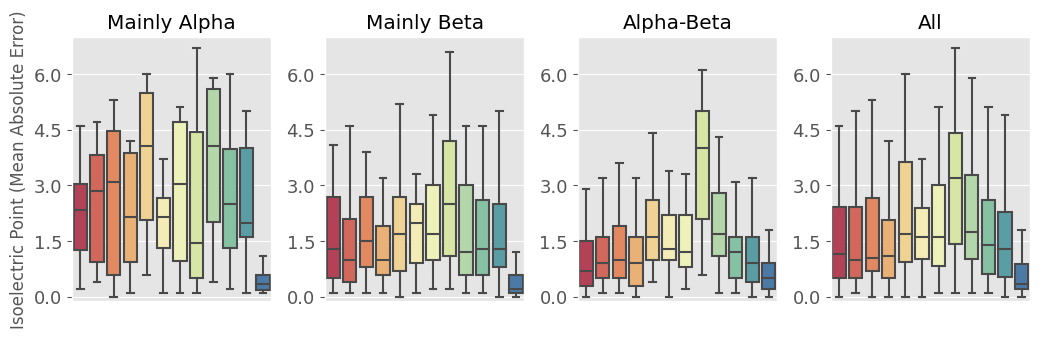

In [30]:
import matplotlib as mpl

mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt

plt.style.use("ggplot")


# plt.rcParams["figure.figsize"] = (10, 5)

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

def set_size(width, fraction=1):
    """ Set aesthetic figure dimensions to avoid scaling in latex.

    Parameters
    ----------
    width: float
            Width in pts
    fraction: float
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5 ** 0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio / 2

    return fig_width_in, fig_height_in


RMSD_100 = True


class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
new_df.sort_values(by="PDB", inplace=True)
pdb_class_map = new_df['class'].to_numpy()
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)

axes = [ax, ax2, ax3, ax4]
for c in range(1,5):
    # the figure and axes
    if c < 4:
        current_map = pdb_class_map == c
    else:
        # Select all
        current_map = pdb_class_map != 0

    data_rmsd = []
    data_charge = []
    data_accuracy = []
    sequences = []
    data_recall = []

    median = 0
    for i, model_name in enumerate(model_names):
        df = pd.read_csv(f"performance/{model_name}_performance.csv")
        df.sort_values(by="PDB", inplace=True)

        x = df.iso.to_numpy()
        z = df.accuracy.to_numpy() * 100
        y_nan = df.rmsd.to_numpy()
        # Remove NaN
        y = y_nan[~np.isnan(y_nan)]
        x = x[~np.isnan(y_nan)]
        z = z[~np.isnan(y_nan)]
        # Select current class:
        # try:
        y = y[current_map]
        x = x[current_map]
        z = z[current_map]
        seqs = df.sequence.to_numpy()
        seqs = np.array([len(seq) for seq in seqs])
        sequences = seqs[~np.isnan(y_nan)]

        sequences = sequences[current_map]
        assert len(sequences) == len(y)

        # raise ValueError
        # except:
        #     pass
        #print(f"There are {len(x)} structures for class {c} - {class_names[c-1]}")
        if RMSD_100 == True:
            rmsd_100 = []
            for curr_rsmd, curr_len in zip(y, sequences):
                rmsd_100.append(curr_rsmd / (1 + np.log(curr_len/100)))
            data_rmsd.append(np.array(rmsd_100))
        else:
            data_rmsd.append(y)
        data_charge.append(x)
        data_accuracy.append(x)
        if model_name == "evoEF2":
            median = np.median(y)

    SHOW_OUTLIERS = False
    # Do boxplots
    # 1 - RMSD
    sns.boxplot(data=data_charge, ax = axes[c-1], showfliers = SHOW_OUTLIERS, palette=sns.color_palette("Spectral", n_colors=len(model_names)))
    axes[c-1].set_title(f'{class_names[c-1]}') #, fontsize=20)
    if RMSD_100:
        ax.set_ylabel('Isoelectric Point (Mean Absolute Error)')  # , fontsize=20)
    else:
        ax.set_ylabel('RMSD ($\AA$)') #, fontsize=20)
    axes[c-1].tick_params(axis='x') #, labelsize=18)
    axes[c-1].tick_params(axis='y', labelsize=13)
    axes[c-1].yaxis.set_major_locator(plt.MaxNLocator(5))
    axes[c-1].axes.xaxis.set_visible(False)
    # if c-1 == 0:
    #     axes[c-1].set_ylim(ymin=0, ymax=median+1) #, ymax=np.max(data_rmsd))
    # else:
    axes[c-1].set_ylim(ymin=-.1, ymax=7)
    #axes[c-1].axhline(3,  ls='--')
    
    # 2 - Macro Recall
    # sns.boxplot(data=data_recall, ax = ax2, showfliers = SHOW_OUTLIERS)
    # xtickNames = plt.setp(ax2, xticklabels=models)
    # plt.setp(xtickNames, rotation=45, fontsize=18)
    # ax2.set_ylabel('Macro-Recall (%)', fontsize=20)
    # ax2.tick_params(axis='x', labelsize=13)
    # ax2.tick_params(axis='y', labelsize=18)
    # ax2.set_ylim(ymin=0)
    #
    #
    # sns.boxplot(data=data_accuracy, ax = ax3, showfliers = SHOW_OUTLIERS)
    # xtickNames = plt.setp(ax3, xticklabels=models)
    # plt.setp(xtickNames, rotation=45, fontsize=18)
    # ax3.set_xlabel('Models', fontsize=20)
    # ax3.set_ylabel('Accuracy (%)', fontsize=20)
    # ax3.tick_params(axis='x', labelsize=13)
    # ax3.tick_params(axis='y', labelsize=18)
    # ax3.set_ylim(ymin=0) #, ymax=np.max(data_accuracy))


    del data_rmsd; del data_accuracy; del data_recall
    
plt.tight_layout()
plt.show()
#plt.savefig(f"boxplot_RMSD_Norm_{RMSD_100}.eps", dpi=300)
plt.close()

In [32]:
import matplotlib as mpl

mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt


# plt.rcParams["figure.figsize"] = (10, 5)

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
plt.style.use("ggplot")
palette = sns.color_palette("Spectral", n_colors=len(model_names))

def set_size(width, fraction=1):
    """ Set aesthetic figure dimensions to avoid scaling in latex.

    Parameters
    ----------
    width: float
            Width in pts
    fraction: float
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5 ** 0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio / 2

    return fig_width_in, fig_height_in


RMSD_100 = True


class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
new_df.sort_values(by="PDB", inplace=True)
pdb_class_map = new_df['class'].to_numpy()
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)

axes = [ax, ax2, ax3, ax4]
for c in range(1,5):
    # the figure and axes
    if c < 4:
        current_map = pdb_class_map == c
    else:
        # Select all
        current_map = pdb_class_map != 0

    data_rmsd = []
    data_recall = []
    data_accuracy = []
    sequences = []

    median = 0
    for i, model_name in enumerate(model_names):
        df = pd.read_csv(f"performance/{model_name}_performance.csv")
        df.sort_values(by="PDB", inplace=True)

        x = df.recall.to_numpy() * 100
        z = df.accuracy.to_numpy() * 100
        y_nan = df.rmsd.to_numpy()
        # Remove NaN
        y = y_nan[~np.isnan(y_nan)]
        x = x[~np.isnan(y_nan)]
        z = z[~np.isnan(y_nan)]
        # Select current class:
        # try:
        y = y[current_map]
        x = x[current_map]
        z = z[current_map]
        # print(x)
        # raise ValueError
        # except:
        #     pass
        # print(f"There are {len(x)} structures for class {c} - {class_names[c-1]}")
        print(f"{model_name} has {len(y[y < 2])} for class {class_names[c-1]}")

        data_rmsd.append(y)
        data_recall.append(x)
        data_accuracy.append(x)
        if model_name == "evoEF2":
            median = np.median(y)

        cumulative_rmsd = []
        thresholds = np.arange(0, 10, 2)

        for idx, t in enumerate(thresholds):

            if idx == 0:
                percentage = ((len(y[y < t])) / len(y))
            else:
                percentage = ((len(y[y < t])-cumulative_rmsd[-1]) / len(y))
            cumulative_rmsd.append(percentage)
        if model_name == "default_unbalanced":
            axes[c-1].plot(thresholds, cumulative_rmsd, label=better_names[i], linewidth=5, color=palette[i])
        else:
            axes[c-1].plot(thresholds, cumulative_rmsd, label=better_names[i], linewidth=5, color=palette[i])

    SHOW_OUTLIERS = False
    # Do boxplots
    # 1 - RMSD

    # xtickNames = plt.setp(axes[c-1], xticklabels=models)
    # plt.setp(xtickNames, rotation=90, fontsize=5)
    axes[c-1].set_title(f'{class_names[c-1]}') #, fontsize=20)
    # ax.set_xlabel('RMSD ($\AA$)') #, fontsize=20)
    axes[0].set_ylabel('% Structures (%)') #, fontsize=20)
    # axes[0].set_ylabel('Density') #, fontsize=20)
    # axes[c-1].tick_params(axis='x') #, labelsize=18)
    axes[c-1].tick_params(axis='y', labelsize=13)
    axes[c-1].yaxis.set_major_locator(plt.MaxNLocator(3))
    axes[c-1].xaxis.set_major_locator(plt.MaxNLocator(3))
    # axes[c-1].axvline(2, color='k', linestyle='dashed', linewidth=1)
    # axes[c-1].text(50 * 0.9, 2.2, '2 ($\AA$)', fontsize=18)
    # axes[c-1].yaxis.set_major_locator(plt.MaxNLocator(3))

    # axes[c-1].set_xticklabels(tick_labels.astype(int))
    # axes[c-1].axes.xaxis.set_visible(False)
    # axes[c-1].set_yticklabels([])
    # axes[c-1].set_xticklabels([])
    axes[c-1].set_ylim(ymin=0) #, ymax=np.max(data_rmsd))
    axes[c-1].set_xlim(xmin=0, xmax=6) #, ymax=np.max(data_rmsd))
    # 2 - Macro Recall
    # sns.boxplot(data=data_recall, ax = ax2, showfliers = SHOW_OUTLIERS)
    # xtickNames = plt.setp(ax2, xticklabels=models)
    # plt.setp(xtickNames, rotation=45, fontsize=18)
    # ax2.set_ylabel('Macro-Recall (%)', fontsize=20)
    # ax2.tick_params(axis='x', labelsize=13)
    # ax2.tick_params(axis='y', labelsize=18)
    # ax2.set_ylim(ymin=0)
    #
    #
    # sns.boxplot(data=data_accuracy, ax = ax3, showfliers = SHOW_OUTLIERS)
    # xtickNames = plt.setp(ax3, xticklabels=models)
    # plt.setp(xtickNames, rotation=45, fontsize=18)
    # ax3.set_xlabel('Models', fontsize=20)
    # ax3.set_ylabel('Accuracy (%)', fontsize=20)
    # ax3.tick_params(axis='x', labelsize=13)
    # ax3.tick_params(axis='y', labelsize=18)
    # ax3.set_ylim(ymin=0) #, ymax=np.max(data_accuracy))


    del data_rmsd; del data_accuracy; del data_recall
    
fig.text(0.5, 0.01, 'RMSD ($\AA$)', ha='center')
# plt.legend()
legend = plt.legend(ncol = 4, framealpha=1, frameon=True, bbox_to_anchor=(0.5, -0.15))



def export_legend(legend, filename="legend_small.png", expand=[-5,-5,5,5]):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent()
    bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi=300, bbox_inches=bbox)

export_legend(legend)
# plt.legend([],[], frameon=False)
#
# fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical')
plt.tight_layout()
# plt.savefig(f"hist_RMSD.eps", dpi=300)
plt.close()

evoEF2 has 3 for class Mainly Alpha
rosetta has 6 for class Mainly Alpha
prodconn has 6 for class Mainly Alpha
timed has 8 for class Mainly Alpha
timed_unbalanced has 9 for class Mainly Alpha
timed_deep has 9 for class Mainly Alpha
DenseNet has 9 for class Mainly Alpha
densecpd has 9 for class Mainly Alpha
timed_rotamer has 8 for class Mainly Alpha
timed_rotamer_deep has 9 for class Mainly Alpha
TIMED_polar_fix has 8 for class Mainly Alpha
TIMED_charge has 8 for class Mainly Alpha
evoEF2 has 11 for class Mainly Beta
rosetta has 16 for class Mainly Beta
prodconn has 14 for class Mainly Beta
timed has 15 for class Mainly Beta
timed_unbalanced has 15 for class Mainly Beta
timed_deep has 16 for class Mainly Beta
DenseNet has 16 for class Mainly Beta
densecpd has 15 for class Mainly Beta
timed_rotamer has 16 for class Mainly Beta
timed_rotamer_deep has 17 for class Mainly Beta
TIMED_polar_fix has 16 for class Mainly Beta
TIMED_charge has 17 for class Mainly Beta
evoEF2 has 14 for class Alph

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


TIMED_charge has 47 for class All


/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ipykernel_launcher.py:185: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


In [32]:
df.loc[30]

Unnamed: 0                                                       13
Unnamed: 0.1                                                 118376
PDB                                                            3klk
chain                                                             A
class                                                             2
architecture                                                     10
topology                                                        270
hsf                                                              10
start                                                             0
stop                                                             45
sequence          QYYIDPTTGQPRKNFLLQNGNDWIYFDKDTGAGTNALKLQFDKGTI...
dssp                 EETTTTEE  SEEEEETTEEEEE TTT  EEEGGG    TT  ...
uncommon_index                                                  NaN
resolution                                                 1.650000
accuracy                                        

In [29]:
p = sns.color_palette("hls", len(model_names))


In [31]:
p[0]

(0.86, 0.3712, 0.33999999999999997)

In [41]:
sns.color_palette("muted")


[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41568627450980394, 0.8, 0.39215686274509803),
 (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 (0.5843137254901961, 0.4235294117647059, 0.7058823529411765),
 (0.5490196078431373, 0.3803921568627451, 0.23529411764705882),
 (0.8627450980392157, 0.49411764705882355, 0.7529411764705882),
 (0.4745098039215686, 0.4745098039215686, 0.4745098039215686),
 (0.8352941176470589, 0.7333333333333333, 0.403921568627451),
 (0.5098039215686274, 0.7764705882352941, 0.8862745098039215)]

In [22]:
calculate_seq_metrics(new_df.iloc[0].sequence)

(11.78943899546267, 10.000000000000007)

In [23]:
calculate_seq_metrics(new_df.iloc[1].sequence)

(-13.129709357807064, 5.100000000000003)

In [25]:
abs(calculate_seq_metrics(new_df.iloc[0].sequence)[0] - calculate_seq_metrics(new_df.iloc[1].sequence)[0])

24.919148353269733

## Unrelaxed Models

In [20]:
def get_all_rmsd_unrelaxed(model_name, model_path, pdb_path, pdb_codes):
    pdb_rmsd = []
    pdb_charge = []
    pdb_iso = []
    for pdb_code in pdb_codes:
        baseline_path =  pdb_path / f"{pdb_code[:4]}.pdb1"
        curr_model_path = model_path / f"{model_name}_{pdb_code}A_relaxed_model_4.pdb"
        assert baseline_path.exists(), f"{baseline_path} does not exist"
        if curr_model_path.exists():
            rmsd = calc_rmsd(baseline_path, curr_model_path)
            # Original:
            original_pdb = ampal.load_pdb(baseline_path)
            original_sequence = original_pdb[0].sequences[0]
            ori_charge, ori_iso = calculate_seq_metrics(original_sequence)
            # Designed:
            design_pdb = ampal.load_pdb(curr_model_path)
            print(design_pdb)
            design_sequence = design_pdb.sequences[0]
            des_charge, des_iso = calculate_seq_metrics(design_sequence)
            # Calculate MAE:
            mae_iso = abs(ori_iso - des_iso)
            mae_charge = abs(ori_charge - des_charge)
        else:
            print(f"{curr_model_path} does not exist")
            rmsd = np.nan
            mae_iso = np.nan
            mae_charge = np.nan
        pdb_rmsd.append(rmsd)
        pdb_charge.append(mae_charge)
        pdb_iso.append(mae_iso)
    return pdb_rmsd, pdb_charge, pdb_iso


In [21]:
from copy import copy
for model_name in model_names:
	#model_name = 'skilled-wind-134-timed_hs1000_l2_dp03_weighted'
	path_to_file = Path(f"timed_paper_2023/{model_name}.csv")
	print(model_name)
	print(path_to_file.exists())
	print(path_to_file.with_suffix('.txt').exists())
	# select only monomers
	new_df = copy(df)
	# choose your model
	with open(path_to_file.with_suffix('.txt')) as datasetmap:
	    predictions = get_cath.load_prediction_matrix(new_df,
	                                                  path_to_file.with_suffix(
	                                                      '.txt'), path_to_file)
	accuracy, recall = get_cath.score_each(new_df, predictions, by_fragment=False)
	model_path = path_to_model_structures / model_name
	pdb_rmsd, pdb_charge, pdb_iso = get_all_rmsd_unrelaxed(model_name, model_path, path_to_benchmark_structures, list(new_df.PDB.values))
	new_df['accuracy'] = accuracy
	new_df['recall'] = recall
	new_df['rmsd'] = pdb_rmsd
	new_df['charge'] = pdb_charge
	new_df['iso'] = pdb_iso
	new_df.to_csv(f"performance/{model_name}_model4_performance.csv")

evoEF2
True
True
['1a41', 'evoEF2_1a41A_relaxed_model_4']
<Assembly (evoEF2_1a41A_relaxed_model_4) containing 1 Polypeptide>
['1ds1', 'evoEF2_1ds1A_relaxed_model_4']
<Assembly (evoEF2_1ds1A_relaxed_model_4) containing 1 Polypeptide>
['1dvo', 'evoEF2_1dvoA_relaxed_model_4']
<Assembly (evoEF2_1dvoA_relaxed_model_4) containing 1 Polypeptide>
['1g3p', 'evoEF2_1g3pA_relaxed_model_4']


/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:84: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:123: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:106: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)


<Assembly (evoEF2_1g3pA_relaxed_model_4) containing 1 Polypeptide>
['1h70', 'evoEF2_1h70A_relaxed_model_4']
<Assembly (evoEF2_1h70A_relaxed_model_4) containing 1 Polypeptide>
['1hq0', 'evoEF2_1hq0A_relaxed_model_4']
<Assembly (evoEF2_1hq0A_relaxed_model_4) containing 1 Polypeptide>
['1hxr', 'evoEF2_1hxrA_relaxed_model_4']
<Assembly (evoEF2_1hxrA_relaxed_model_4) containing 1 Polypeptide>
['1jov', 'evoEF2_1jovA_relaxed_model_4']
<Assembly (evoEF2_1jovA_relaxed_model_4) containing 1 Polypeptide>
['1l0s', 'evoEF2_1l0sA_relaxed_model_4']
<Assembly (evoEF2_1l0sA_relaxed_model_4) containing 1 Polypeptide>
['1o7i', 'evoEF2_1o7iA_relaxed_model_4']
<Assembly (evoEF2_1o7iA_relaxed_model_4) containing 1 Polypeptide>
['1uzk', 'evoEF2_1uzkA_relaxed_model_4']
<Assembly (evoEF2_1uzkA_relaxed_model_4) containing 1 Polypeptide>
['1x8q', 'evoEF2_1x8qA_relaxed_model_4']
<Assembly (evoEF2_1x8qA_relaxed_model_4) containing 1 Polypeptide>
['2bhu', 'evoEF2_2bhuA_relaxed_model_4']
<Assembly (evoEF2_2bhuA_rela

/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:84: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:123: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:106: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)


<Assembly (rosetta_1g3pA_relaxed_model_4) containing 1 Polypeptide>
['1h70', 'rosetta_1h70A_relaxed_model_4']
<Assembly (rosetta_1h70A_relaxed_model_4) containing 1 Polypeptide>
['1hq0', 'rosetta_1hq0A_relaxed_model_4']
<Assembly (rosetta_1hq0A_relaxed_model_4) containing 1 Polypeptide>
['1hxr', 'rosetta_1hxrA_relaxed_model_4']
<Assembly (rosetta_1hxrA_relaxed_model_4) containing 1 Polypeptide>
['1jov', 'rosetta_1jovA_relaxed_model_4']
<Assembly (rosetta_1jovA_relaxed_model_4) containing 1 Polypeptide>
['1l0s', 'rosetta_1l0sA_relaxed_model_4']
<Assembly (rosetta_1l0sA_relaxed_model_4) containing 1 Polypeptide>
['1o7i', 'rosetta_1o7iA_relaxed_model_4']
<Assembly (rosetta_1o7iA_relaxed_model_4) containing 1 Polypeptide>
['1uzk', 'rosetta_1uzkA_relaxed_model_4']
<Assembly (rosetta_1uzkA_relaxed_model_4) containing 1 Polypeptide>
['1x8q', 'rosetta_1x8qA_relaxed_model_4']
<Assembly (rosetta_1x8qA_relaxed_model_4) containing 1 Polypeptide>
['2bhu', 'rosetta_2bhuA_relaxed_model_4']
<Assembly 

/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:84: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:123: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:106: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)


<Assembly (prodconn_1g3pA_relaxed_model_4) containing 1 Polypeptide>
['1h70', 'prodconn_1h70A_relaxed_model_4']
<Assembly (prodconn_1h70A_relaxed_model_4) containing 1 Polypeptide>
['1hq0', 'prodconn_1hq0A_relaxed_model_4']
<Assembly (prodconn_1hq0A_relaxed_model_4) containing 1 Polypeptide>
['1hxr', 'prodconn_1hxrA_relaxed_model_4']
<Assembly (prodconn_1hxrA_relaxed_model_4) containing 1 Polypeptide>
['1jov', 'prodconn_1jovA_relaxed_model_4']
<Assembly (prodconn_1jovA_relaxed_model_4) containing 1 Polypeptide>
['1l0s', 'prodconn_1l0sA_relaxed_model_4']
<Assembly (prodconn_1l0sA_relaxed_model_4) containing 1 Polypeptide>
['1o7i', 'prodconn_1o7iA_relaxed_model_4']
<Assembly (prodconn_1o7iA_relaxed_model_4) containing 1 Polypeptide>
['1uzk', 'prodconn_1uzkA_relaxed_model_4']
<Assembly (prodconn_1uzkA_relaxed_model_4) containing 1 Polypeptide>
['1x8q', 'prodconn_1x8qA_relaxed_model_4']
<Assembly (prodconn_1x8qA_relaxed_model_4) containing 1 Polypeptide>
['2bhu', 'prodconn_2bhuA_relaxed_mo

/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:84: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:123: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:106: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)


<Assembly (timed_1h70A_relaxed_model_4) containing 1 Polypeptide>
['1hq0', 'timed_1hq0A_relaxed_model_4']
<Assembly (timed_1hq0A_relaxed_model_4) containing 1 Polypeptide>
['1hxr', 'timed_1hxrA_relaxed_model_4']
<Assembly (timed_1hxrA_relaxed_model_4) containing 1 Polypeptide>
['1jov', 'timed_1jovA_relaxed_model_4']
<Assembly (timed_1jovA_relaxed_model_4) containing 1 Polypeptide>
['1l0s', 'timed_1l0sA_relaxed_model_4']
<Assembly (timed_1l0sA_relaxed_model_4) containing 1 Polypeptide>
['1o7i', 'timed_1o7iA_relaxed_model_4']
<Assembly (timed_1o7iA_relaxed_model_4) containing 1 Polypeptide>
['1uzk', 'timed_1uzkA_relaxed_model_4']
<Assembly (timed_1uzkA_relaxed_model_4) containing 1 Polypeptide>
['1x8q', 'timed_1x8qA_relaxed_model_4']
<Assembly (timed_1x8qA_relaxed_model_4) containing 1 Polypeptide>
['2bhu', 'timed_2bhuA_relaxed_model_4']
<Assembly (timed_2bhuA_relaxed_model_4) containing 1 Polypeptide>
['2dyi', 'timed_2dyiA_relaxed_model_4']
<Assembly (timed_2dyiA_relaxed_model_4) contai

/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:84: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:123: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:106: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)


<Assembly (timed_unbalanced_1h70A_relaxed_model_4) containing 1 Polypeptide>
['1hq0', 'timed_unbalanced_1hq0A_relaxed_model_4']
<Assembly (timed_unbalanced_1hq0A_relaxed_model_4) containing 1 Polypeptide>
['1hxr', 'timed_unbalanced_1hxrA_relaxed_model_4']
<Assembly (timed_unbalanced_1hxrA_relaxed_model_4) containing 1 Polypeptide>
['1jov', 'timed_unbalanced_1jovA_relaxed_model_4']
<Assembly (timed_unbalanced_1jovA_relaxed_model_4) containing 1 Polypeptide>
['1l0s', 'timed_unbalanced_1l0sA_relaxed_model_4']
<Assembly (timed_unbalanced_1l0sA_relaxed_model_4) containing 1 Polypeptide>
['1o7i', 'timed_unbalanced_1o7iA_relaxed_model_4']
<Assembly (timed_unbalanced_1o7iA_relaxed_model_4) containing 1 Polypeptide>
['1uzk', 'timed_unbalanced_1uzkA_relaxed_model_4']
<Assembly (timed_unbalanced_1uzkA_relaxed_model_4) containing 1 Polypeptide>
['1x8q', 'timed_unbalanced_1x8qA_relaxed_model_4']
<Assembly (timed_unbalanced_1x8qA_relaxed_model_4) containing 1 Polypeptide>
['2bhu', 'timed_unbalanced_

/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:84: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:123: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:106: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)


<Assembly (timed_deep_1g3pA_relaxed_model_4) containing 1 Polypeptide>
['1h70', 'timed_deep_1h70A_relaxed_model_4']
<Assembly (timed_deep_1h70A_relaxed_model_4) containing 1 Polypeptide>
['1hq0', 'timed_deep_1hq0A_relaxed_model_4']
<Assembly (timed_deep_1hq0A_relaxed_model_4) containing 1 Polypeptide>
['1hxr', 'timed_deep_1hxrA_relaxed_model_4']
<Assembly (timed_deep_1hxrA_relaxed_model_4) containing 1 Polypeptide>
['1jov', 'timed_deep_1jovA_relaxed_model_4']
<Assembly (timed_deep_1jovA_relaxed_model_4) containing 1 Polypeptide>
['1l0s', 'timed_deep_1l0sA_relaxed_model_4']
<Assembly (timed_deep_1l0sA_relaxed_model_4) containing 1 Polypeptide>
['1o7i', 'timed_deep_1o7iA_relaxed_model_4']
<Assembly (timed_deep_1o7iA_relaxed_model_4) containing 1 Polypeptide>
['1uzk', 'timed_deep_1uzkA_relaxed_model_4']
<Assembly (timed_deep_1uzkA_relaxed_model_4) containing 1 Polypeptide>
['1x8q', 'timed_deep_1x8qA_relaxed_model_4']
<Assembly (timed_deep_1x8qA_relaxed_model_4) containing 1 Polypeptide>
[

/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:84: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:123: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:106: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)


<Assembly (DenseNet_1g3pA_relaxed_model_4) containing 1 Polypeptide>
['1h70', 'DenseNet_1h70A_relaxed_model_4']
<Assembly (DenseNet_1h70A_relaxed_model_4) containing 1 Polypeptide>
['1hq0', 'DenseNet_1hq0A_relaxed_model_4']
<Assembly (DenseNet_1hq0A_relaxed_model_4) containing 1 Polypeptide>
['1hxr', 'DenseNet_1hxrA_relaxed_model_4']
<Assembly (DenseNet_1hxrA_relaxed_model_4) containing 1 Polypeptide>
['1jov', 'DenseNet_1jovA_relaxed_model_4']
<Assembly (DenseNet_1jovA_relaxed_model_4) containing 1 Polypeptide>
['1l0s', 'DenseNet_1l0sA_relaxed_model_4']
<Assembly (DenseNet_1l0sA_relaxed_model_4) containing 1 Polypeptide>
['1o7i', 'DenseNet_1o7iA_relaxed_model_4']
<Assembly (DenseNet_1o7iA_relaxed_model_4) containing 1 Polypeptide>
['1uzk', 'DenseNet_1uzkA_relaxed_model_4']
<Assembly (DenseNet_1uzkA_relaxed_model_4) containing 1 Polypeptide>
['1x8q', 'DenseNet_1x8qA_relaxed_model_4']
<Assembly (DenseNet_1x8qA_relaxed_model_4) containing 1 Polypeptide>
['2bhu', 'DenseNet_2bhuA_relaxed_mo

/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:84: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:123: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:106: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)


<Assembly (densecpd_1g3pA_relaxed_model_4) containing 1 Polypeptide>
['1h70', 'densecpd_1h70A_relaxed_model_4']
<Assembly (densecpd_1h70A_relaxed_model_4) containing 1 Polypeptide>
['1hq0', 'densecpd_1hq0A_relaxed_model_4']
<Assembly (densecpd_1hq0A_relaxed_model_4) containing 1 Polypeptide>
['1hxr', 'densecpd_1hxrA_relaxed_model_4']
<Assembly (densecpd_1hxrA_relaxed_model_4) containing 1 Polypeptide>
['1jov', 'densecpd_1jovA_relaxed_model_4']
<Assembly (densecpd_1jovA_relaxed_model_4) containing 1 Polypeptide>
['1l0s', 'densecpd_1l0sA_relaxed_model_4']
<Assembly (densecpd_1l0sA_relaxed_model_4) containing 1 Polypeptide>
['1o7i', 'densecpd_1o7iA_relaxed_model_4']
<Assembly (densecpd_1o7iA_relaxed_model_4) containing 1 Polypeptide>
['1uzk', 'densecpd_1uzkA_relaxed_model_4']
<Assembly (densecpd_1uzkA_relaxed_model_4) containing 1 Polypeptide>
['1x8q', 'densecpd_1x8qA_relaxed_model_4']
<Assembly (densecpd_1x8qA_relaxed_model_4) containing 1 Polypeptide>
['2bhu', 'densecpd_2bhuA_relaxed_mo

/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:84: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:123: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:106: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)


<Assembly (timed_rotamer_1g3pA_relaxed_model_4) containing 1 Polypeptide>
['1h70', 'timed_rotamer_1h70A_relaxed_model_4']
<Assembly (timed_rotamer_1h70A_relaxed_model_4) containing 1 Polypeptide>
['1hq0', 'timed_rotamer_1hq0A_relaxed_model_4']
<Assembly (timed_rotamer_1hq0A_relaxed_model_4) containing 1 Polypeptide>
['1hxr', 'timed_rotamer_1hxrA_relaxed_model_4']
<Assembly (timed_rotamer_1hxrA_relaxed_model_4) containing 1 Polypeptide>
['1jov', 'timed_rotamer_1jovA_relaxed_model_4']
<Assembly (timed_rotamer_1jovA_relaxed_model_4) containing 1 Polypeptide>
['1l0s', 'timed_rotamer_1l0sA_relaxed_model_4']
<Assembly (timed_rotamer_1l0sA_relaxed_model_4) containing 1 Polypeptide>
['1o7i', 'timed_rotamer_1o7iA_relaxed_model_4']
<Assembly (timed_rotamer_1o7iA_relaxed_model_4) containing 1 Polypeptide>
['1uzk', 'timed_rotamer_1uzkA_relaxed_model_4']
<Assembly (timed_rotamer_1uzkA_relaxed_model_4) containing 1 Polypeptide>
['1x8q', 'timed_rotamer_1x8qA_relaxed_model_4']
<Assembly (timed_rotamer

/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:84: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:123: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:106: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)


<Assembly (timed_rotamer_deep_1g3pA_relaxed_model_4) containing 1 Polypeptide>
['1h70', 'timed_rotamer_deep_1h70A_relaxed_model_4']
<Assembly (timed_rotamer_deep_1h70A_relaxed_model_4) containing 1 Polypeptide>
['1hq0', 'timed_rotamer_deep_1hq0A_relaxed_model_4']
<Assembly (timed_rotamer_deep_1hq0A_relaxed_model_4) containing 1 Polypeptide>
['1hxr', 'timed_rotamer_deep_1hxrA_relaxed_model_4']
<Assembly (timed_rotamer_deep_1hxrA_relaxed_model_4) containing 1 Polypeptide>
['1jov', 'timed_rotamer_deep_1jovA_relaxed_model_4']
<Assembly (timed_rotamer_deep_1jovA_relaxed_model_4) containing 1 Polypeptide>
['1l0s', 'timed_rotamer_deep_1l0sA_relaxed_model_4']
<Assembly (timed_rotamer_deep_1l0sA_relaxed_model_4) containing 1 Polypeptide>
['1o7i', 'timed_rotamer_deep_1o7iA_relaxed_model_4']
<Assembly (timed_rotamer_deep_1o7iA_relaxed_model_4) containing 1 Polypeptide>
['1uzk', 'timed_rotamer_deep_1uzkA_relaxed_model_4']
<Assembly (timed_rotamer_deep_1uzkA_relaxed_model_4) containing 1 Polypeptid

/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:84: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:123: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:106: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)


<Assembly (TIMED_polar_fix_1g3pA_relaxed_model_4) containing 1 Polypeptide>
['1h70', 'TIMED_polar_fix_1h70A_relaxed_model_4']
<Assembly (TIMED_polar_fix_1h70A_relaxed_model_4) containing 1 Polypeptide>
['1hq0', 'TIMED_polar_fix_1hq0A_relaxed_model_4']
<Assembly (TIMED_polar_fix_1hq0A_relaxed_model_4) containing 1 Polypeptide>
['1hxr', 'TIMED_polar_fix_1hxrA_relaxed_model_4']
<Assembly (TIMED_polar_fix_1hxrA_relaxed_model_4) containing 1 Polypeptide>
['1jov', 'TIMED_polar_fix_1jovA_relaxed_model_4']
<Assembly (TIMED_polar_fix_1jovA_relaxed_model_4) containing 1 Polypeptide>
['1l0s', 'TIMED_polar_fix_1l0sA_relaxed_model_4']
<Assembly (TIMED_polar_fix_1l0sA_relaxed_model_4) containing 1 Polypeptide>
['1o7i', 'TIMED_polar_fix_1o7iA_relaxed_model_4']
<Assembly (TIMED_polar_fix_1o7iA_relaxed_model_4) containing 1 Polypeptide>
['1uzk', 'TIMED_polar_fix_1uzkA_relaxed_model_4']
<Assembly (TIMED_polar_fix_1uzkA_relaxed_model_4) containing 1 Polypeptide>
['1x8q', 'TIMED_polar_fix_1x8qA_relaxed_mo

/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:84: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:123: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/ampal/analyse_protein.py:106: NoncanonicalWarning: Unnatural amino acid detected, this value may be inaccurate.
  warnings.warn(_nc_warning_str, NoncanonicalWarning)


<Assembly (TIMED_charge_1g3pA_relaxed_model_4) containing 1 Polypeptide>
['1h70', 'TIMED_charge_1h70A_relaxed_model_4']
<Assembly (TIMED_charge_1h70A_relaxed_model_4) containing 1 Polypeptide>
['1hq0', 'TIMED_charge_1hq0A_relaxed_model_4']
<Assembly (TIMED_charge_1hq0A_relaxed_model_4) containing 1 Polypeptide>
['1hxr', 'TIMED_charge_1hxrA_relaxed_model_4']
<Assembly (TIMED_charge_1hxrA_relaxed_model_4) containing 1 Polypeptide>
['1jov', 'TIMED_charge_1jovA_relaxed_model_4']
<Assembly (TIMED_charge_1jovA_relaxed_model_4) containing 1 Polypeptide>
['1l0s', 'TIMED_charge_1l0sA_relaxed_model_4']
<Assembly (TIMED_charge_1l0sA_relaxed_model_4) containing 1 Polypeptide>
['1o7i', 'TIMED_charge_1o7iA_relaxed_model_4']
<Assembly (TIMED_charge_1o7iA_relaxed_model_4) containing 1 Polypeptide>
['1uzk', 'TIMED_charge_1uzkA_relaxed_model_4']
<Assembly (TIMED_charge_1uzkA_relaxed_model_4) containing 1 Polypeptide>
['1x8q', 'TIMED_charge_1x8qA_relaxed_model_4']
<Assembly (TIMED_charge_1x8qA_relaxed_mo

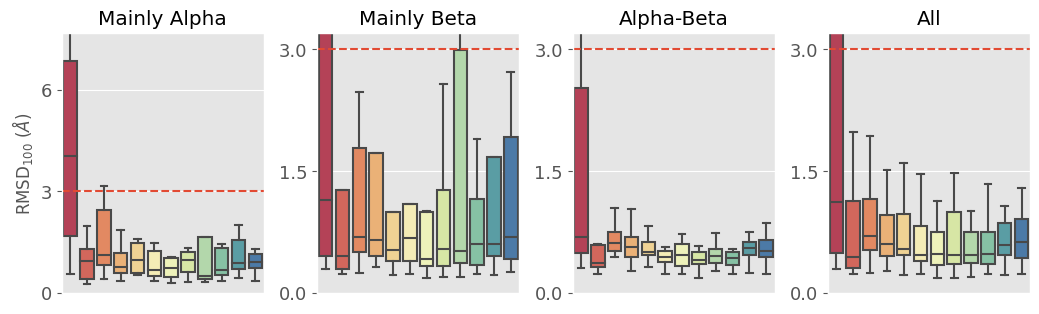

In [22]:
import matplotlib as mpl

mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt

plt.style.use("ggplot")


# plt.rcParams["figure.figsize"] = (10, 5)

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

def set_size(width, fraction=1):
    """ Set aesthetic figure dimensions to avoid scaling in latex.

    Parameters
    ----------
    width: float
            Width in pts
    fraction: float
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5 ** 0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio / 2

    return fig_width_in, fig_height_in


RMSD_100 = True


class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
new_df.sort_values(by="PDB", inplace=True)
pdb_class_map = new_df['class'].to_numpy()
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)

axes = [ax, ax2, ax3, ax4]
for c in range(1,5):
    # the figure and axes
    if c < 4:
        current_map = pdb_class_map == c
    else:
        # Select all
        current_map = pdb_class_map != 0

    data_rmsd = []
    data_recall = []
    data_accuracy = []
    sequences = []

    median = 0
    for i, model_name in enumerate(model_names):
        df = pd.read_csv(f"performance/{model_name}_model4_performance.csv")
        df.sort_values(by="PDB", inplace=True)

        x = df.recall.to_numpy() * 100
        z = df.accuracy.to_numpy() * 100
        y_nan = df.rmsd.to_numpy()
        # Remove NaN
        y = y_nan[~np.isnan(y_nan)]
        x = x[~np.isnan(y_nan)]
        z = z[~np.isnan(y_nan)]
        # Select current class:
        # try:
        y = y[current_map]
        x = x[current_map]
        z = z[current_map]
        seqs = df.sequence.to_numpy()
        seqs = np.array([len(seq) for seq in seqs])
        sequences = seqs[~np.isnan(y_nan)]

        sequences = sequences[current_map]
        assert len(sequences) == len(y)

        # raise ValueError
        # except:
        #     pass
        #print(f"There are {len(x)} structures for class {c} - {class_names[c-1]}")
        if RMSD_100 == True:
            rmsd_100 = []
            for curr_rsmd, curr_len in zip(y, sequences):
                rmsd_100.append(curr_rsmd / (1 + np.log(curr_len/100)))
            data_rmsd.append(np.array(rmsd_100))
        else:
            data_rmsd.append(y)
        data_recall.append(x)
        data_accuracy.append(x)
        if model_name == "evoEF2":
            median = np.median(y)

    SHOW_OUTLIERS = False
    # Do boxplots
    # 1 - RMSD
    sns.boxplot(data=data_rmsd, ax = axes[c-1], showfliers = SHOW_OUTLIERS, palette=sns.color_palette("Spectral", n_colors=len(model_names)))
    axes[c-1].set_title(f'{class_names[c-1]}') #, fontsize=20)
    if RMSD_100:
        ax.set_ylabel('RMSD$_{100}$ ($\AA$)')  # , fontsize=20)
    else:
        ax.set_ylabel('RMSD ($\AA$)') #, fontsize=20)
    axes[c-1].tick_params(axis='x') #, labelsize=18)
    axes[c-1].tick_params(axis='y', labelsize=13)
    axes[c-1].yaxis.set_major_locator(plt.MaxNLocator(3))
    axes[c-1].axes.xaxis.set_visible(False)
    if c-1 == 0:
        axes[c-1].set_ylim(ymin=0, ymax=median+1) #, ymax=np.max(data_rmsd))
    else:
        axes[c-1].set_ylim(ymin=0, ymax=3.2)
    axes[c-1].axhline(3,  ls='--')
    
    # 2 - Macro Recall
    # sns.boxplot(data=data_recall, ax = ax2, showfliers = SHOW_OUTLIERS)
    # xtickNames = plt.setp(ax2, xticklabels=models)
    # plt.setp(xtickNames, rotation=45, fontsize=18)
    # ax2.set_ylabel('Macro-Recall (%)', fontsize=20)
    # ax2.tick_params(axis='x', labelsize=13)
    # ax2.tick_params(axis='y', labelsize=18)
    # ax2.set_ylim(ymin=0)
    #
    #
    # sns.boxplot(data=data_accuracy, ax = ax3, showfliers = SHOW_OUTLIERS)
    # xtickNames = plt.setp(ax3, xticklabels=models)
    # plt.setp(xtickNames, rotation=45, fontsize=18)
    # ax3.set_xlabel('Models', fontsize=20)
    # ax3.set_ylabel('Accuracy (%)', fontsize=20)
    # ax3.tick_params(axis='x', labelsize=13)
    # ax3.tick_params(axis='y', labelsize=18)
    # ax3.set_ylim(ymin=0) #, ymax=np.max(data_accuracy))


    del data_rmsd; del data_accuracy; del data_recall
    
plt.tight_layout()
plt.show()
#plt.savefig(f"boxplot_RMSD_Norm_{RMSD_100}.eps", dpi=300)
plt.close()

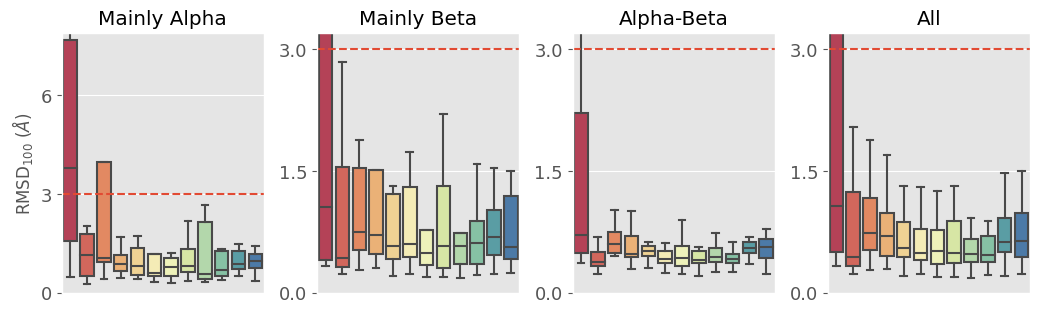

In [17]:
import matplotlib as mpl

mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt

plt.style.use("ggplot")


# plt.rcParams["figure.figsize"] = (10, 5)

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

def set_size(width, fraction=1):
    """ Set aesthetic figure dimensions to avoid scaling in latex.

    Parameters
    ----------
    width: float
            Width in pts
    fraction: float
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5 ** 0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio / 2

    return fig_width_in, fig_height_in


RMSD_100 = True


class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
new_df.sort_values(by="PDB", inplace=True)
pdb_class_map = new_df['class'].to_numpy()
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)

axes = [ax, ax2, ax3, ax4]
for c in range(1,5):
    # the figure and axes
    if c < 4:
        current_map = pdb_class_map == c
    else:
        # Select all
        current_map = pdb_class_map != 0

    data_rmsd = []
    data_recall = []
    data_accuracy = []
    sequences = []

    median = 0
    for i, model_name in enumerate(model_names):
        df = pd.read_csv(f"performance/{model_name}_performance.csv")
        df.sort_values(by="PDB", inplace=True)

        x = df.recall.to_numpy() * 100
        z = df.accuracy.to_numpy() * 100
        y_nan = df.rmsd.to_numpy()
        # Remove NaN
        y = y_nan[~np.isnan(y_nan)]
        x = x[~np.isnan(y_nan)]
        z = z[~np.isnan(y_nan)]
        # Select current class:
        # try:
        y = y[current_map]
        x = x[current_map]
        z = z[current_map]
        seqs = df.sequence.to_numpy()
        seqs = np.array([len(seq) for seq in seqs])
        sequences = seqs[~np.isnan(y_nan)]

        sequences = sequences[current_map]
        assert len(sequences) == len(y)

        # raise ValueError
        # except:
        #     pass
        #print(f"There are {len(x)} structures for class {c} - {class_names[c-1]}")
        if RMSD_100 == True:
            rmsd_100 = []
            for curr_rsmd, curr_len in zip(y, sequences):
                rmsd_100.append(curr_rsmd / (1 + np.log(curr_len/100)))
            data_rmsd.append(np.array(rmsd_100))
        else:
            data_rmsd.append(y)
        data_recall.append(x)
        data_accuracy.append(x)
        if model_name == "evoEF2":
            median = np.median(y)

    SHOW_OUTLIERS = False
    # Do boxplots
    # 1 - RMSD
    sns.boxplot(data=data_rmsd, ax = axes[c-1], showfliers = SHOW_OUTLIERS, palette=sns.color_palette("Spectral", n_colors=len(model_names)))
    axes[c-1].set_title(f'{class_names[c-1]}') #, fontsize=20)
    if RMSD_100:
        ax.set_ylabel('RMSD$_{100}$ ($\AA$)')  # , fontsize=20)
    else:
        ax.set_ylabel('RMSD ($\AA$)') #, fontsize=20)
    axes[c-1].tick_params(axis='x') #, labelsize=18)
    axes[c-1].tick_params(axis='y', labelsize=13)
    axes[c-1].yaxis.set_major_locator(plt.MaxNLocator(3))
    axes[c-1].axes.xaxis.set_visible(False)
    if c-1 == 0:
        axes[c-1].set_ylim(ymin=0, ymax=median+1) #, ymax=np.max(data_rmsd))
    else:
        axes[c-1].set_ylim(ymin=0, ymax=3.2)
    axes[c-1].axhline(3,  ls='--')
    
    # 2 - Macro Recall
    # sns.boxplot(data=data_recall, ax = ax2, showfliers = SHOW_OUTLIERS)
    # xtickNames = plt.setp(ax2, xticklabels=models)
    # plt.setp(xtickNames, rotation=45, fontsize=18)
    # ax2.set_ylabel('Macro-Recall (%)', fontsize=20)
    # ax2.tick_params(axis='x', labelsize=13)
    # ax2.tick_params(axis='y', labelsize=18)
    # ax2.set_ylim(ymin=0)
    #
    #
    # sns.boxplot(data=data_accuracy, ax = ax3, showfliers = SHOW_OUTLIERS)
    # xtickNames = plt.setp(ax3, xticklabels=models)
    # plt.setp(xtickNames, rotation=45, fontsize=18)
    # ax3.set_xlabel('Models', fontsize=20)
    # ax3.set_ylabel('Accuracy (%)', fontsize=20)
    # ax3.tick_params(axis='x', labelsize=13)
    # ax3.tick_params(axis='y', labelsize=18)
    # ax3.set_ylim(ymin=0) #, ymax=np.max(data_accuracy))


    del data_rmsd; del data_accuracy; del data_recall
    
plt.tight_layout()
plt.show()
#plt.savefig(f"boxplot_RMSD_Norm_{RMSD_100}.eps", dpi=300)
plt.close()

# RSMD Correlations

In [9]:
from pathlib import Path
path_to_correlations = Path("/scratch/af2_model-comparison/publication_uncertainty/analysis/")
pack_density_mode = "backbone"
path_to_correlations = path_to_correlations / pack_density_mode
path_to_correlations

PosixPath('/scratch/af2_model-comparison/publication_uncertainty/analysis/backbone')

In [10]:
results_arr = []
columns = [
    "model",
    "pdb",
    "n",
    "temp",
    "seq_accuracy",
    "curr_entropy_mean",
    "curr_entropy_std",
    "curr_packdensity_mean",
    "curr_packdensity_std",
    "real_packdensity_mean",
    "real_packdensity_std",
    "curr_bfactor_mean",
    "curr_bfactor_std",
    "curr_rmsd",
]
for curr_model in [
    "TIMED-rotamer-deep-rot",
    "TIMED-rotamer-rot",
    "TIMED",
    "TIMED-Deep",

]:
    curr_model_path = path_to_correlations / f"all_results_{curr_model}-{pack_density_mode}.csv"
    assert curr_model_path.exists(), f"Input file {curr_model_path} does not exist"
    # Load results in pandas:
    df = pd.read_csv(curr_model_path, header=None)
    df.dropna(inplace=True)
    results_arr += df.values.tolist()
# Merge all together:
results_arr = pd.DataFrame(results_arr, columns=columns)

In [11]:
results_arr.pdb =  results_arr.pdb.str.lstrip()
np.savetxt('temp_structures.txt', results_arr.pdb.unique(), delimiter='\n', fmt='%s')
temp_df = get_cath.filter_with_user_list(cath_df, 'temp_structures.txt')
temp_df.head()

,PDB,chain,class,architecture,topology,hsf,start,stop
63148,1h32,A,1,10,760,10,1,54
71296,1dvo,A,1,10,1710,10,33,184
86819,1a41,A,1,20,120,380,217,310
112599,1gxm,A,1,50,10,20,326,649
113522,1bx7,A,2,10,22,10,3,53


### Add class to structure

In [12]:
for pdb_code in temp_df.PDB.unique():
    results_arr.loc[results_arr['pdb']==f"{pdb_code}A",'class'] = int(temp_df[temp_df['PDB']==pdb_code]['class'])
results_arr['seq_accuracy'] = results_arr['seq_accuracy'].mul(100)

results_arr.head()

,model,pdb,n,temp,seq_accuracy,curr_entropy_mean,curr_entropy_std,curr_packdensity_mean,curr_packdensity_std,real_packdensity_mean,real_packdensity_std,curr_bfactor_mean,curr_bfactor_std,curr_rmsd,class
0,TIMED-rotamer-deep-rot,1io0A,0,0.2,47.590361,7.242881,1.102802,58.956325,11.375917,67.697289,10.086656,97.264398,4.515090,0.547482,3.0
1,TIMED-rotamer-deep-rot,1k5nA,2,1.0,25.724638,6.759802,1.881626,52.969203,12.209369,70.831522,10.751129,46.890435,10.708637,5.031146,2.0
2,TIMED-rotamer-deep-rot,1j3aA,16,1.0,22.480620,7.101529,1.655648,46.888566,10.922219,61.991279,11.313368,74.936434,13.571790,5.877323,3.0
3,TIMED-rotamer-deep-rot,1igqA,13,0.6,22.222222,7.647959,0.301125,51.465278,15.159213,61.497685,13.034176,83.934815,14.260154,1.156149,2.0
4,TIMED-rotamer-deep-rot,1muwA,3,0.2,49.481865,7.139205,1.586126,57.140868,13.175462,65.497409,12.341737,91.559067,10.828318,1.410127,3.0


In [13]:
results_arr.loc[results_arr['model']=="TIMED-rotamer-deep-rot", "model"] = "TIMED_Rotamer_Deep"
results_arr.loc[results_arr['model']=="TIMED-rotamer-rot", "model"] = "TIMED_Rotamer"
results_arr.loc[results_arr['model']=="TIMED-Deep", "model"] = "TIMED_Deep"
results_arr.sort_values(by="model", inplace=True)

## Confidence of sequence model from entropy

### Accuracy vs RMSD

In [14]:
def set_size(width, fraction=1):
    """ Set aesthetic figure dimensions to avoid scaling in latex.

    Parameters
    ----------
    width: float
            Width in pts
    fraction: float
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5 ** 0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio / 2

    return fig_width_in, fig_height_in



Text(0.5, -0.04, 'RMSD ($\\AA$)')

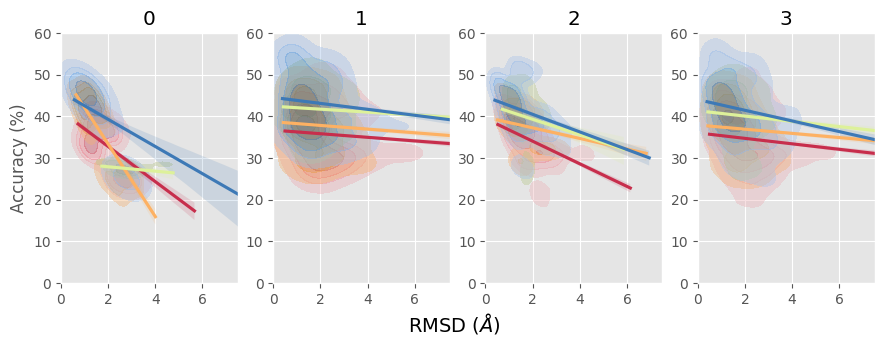

In [99]:
import matplotlib as mpl
from scipy.stats import pearsonr

from benchmark.config import classes
mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
pal = sns.color_palette("Spectral", n_colors=len(model_names))
new_palette = [pal[0], pal[3], pal[7], pal[-1]]
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)
axes = [ax, ax2, ax3, ax4]
results_corr = []
class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
selected_x = "curr_rmsd"
selected_y = "seq_accuracy"
for i, curr_ax in enumerate(axes):
    if i < 3:
        sns.kdeplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1)], x=selected_x, y=selected_y, hue="model", legend=False, palette=new_palette, alpha=0.4, fill=True, thresh=0.15, levels=5, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")], x=selected_x, y=selected_y, scatter=False,line_kws={"color": new_palette[0]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")], x=selected_x, y=selected_y, scatter=False,line_kws={"color": new_palette[1]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")], x=selected_x, y=selected_y, scatter=False,line_kws={"color": new_palette[2]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")], x=selected_x, y=selected_y, scatter=False,line_kws={"color": new_palette[3]}, ax=curr_ax)        
        # Correlations:
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")][selected_y]
        results_corr.append(["TIMED", i, 0.2, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")][selected_y]
        results_corr.append(["TIMED_Deep", i, 0.2, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")][selected_y]
        results_corr.append(["TIMED_Rotamer", i, 0.2, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_y]
        results_corr.append(["TIMED_Rotamer_Deep", i, 0.2, *pearsonr(curr_x,curr_y)])
    else:
        sns.kdeplot(data=results_arr[(results_arr['temp']==0.2)], x=selected_x, y=selected_y, hue="model", legend=False, palette=new_palette, alpha=0.4, fill=True, thresh=0.15, levels=5, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED")], x=selected_x, y=selected_y, scatter=False,line_kws={"color": new_palette[0]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Deep")], x=selected_x, y=selected_y, scatter=False,line_kws={"color": new_palette[1]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Rotamer")], x=selected_x, y=selected_y, scatter=False,line_kws={"color": new_palette[2]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Rotamer_Deep")], x=selected_x, y=selected_y, scatter=False,line_kws={"color": new_palette[3]}, ax=curr_ax)
        # Correlations:
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED")][selected_y]
        results_corr.append(["TIMED", i, 0.2, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Deep")][selected_y]
        results_corr.append(["TIMED_Deep", i, 0.2, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Rotamer")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Rotamer")][selected_y]
        results_corr.append(["TIMED_Rotamer", i, 0.2, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_y]
        results_corr.append(["TIMED_Rotamer_Deep", i, 0.2, *pearsonr(curr_x,curr_y)])
    curr_ax.set_title(class_names[i])

    curr_ax.set_xlim(0, 7.5)
    curr_ax.set_ylim(0, 60)
    if i==0:
        curr_ax.set_ylabel("Accuracy (%)")
    else:
        curr_ax.set_ylabel("")
    curr_ax.set_xlabel("")
    
    # Calculate correlations:
    #     curr_ax.axes.xaxis.set_visible(False)
    # curr_ax.axes.yaxis.set_visible(False)

    
    
# fig.add_subplot(111, frameon=False)
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
fig.text(0.5, -0.04, r"RMSD ($\AA$)", ha='center', fontsize=14)
# fig.subplots_adjust(wspace=0.05, hspace=0.3)

#plt.show()

Text(0.5, -0.04, 'RMSD ($\\AA$)')

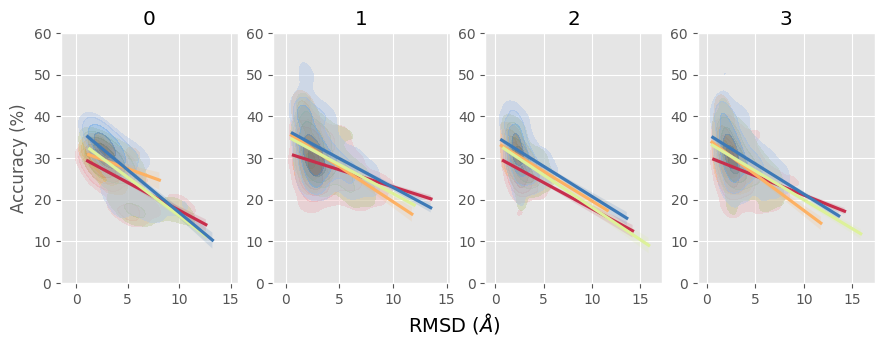

In [101]:
import matplotlib as mpl
from scipy.stats import pearsonr

from benchmark.config import classes
mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
pal = sns.color_palette("Spectral", n_colors=len(model_names))
new_palette = [pal[0], pal[3], pal[7], pal[-1]]
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)
axes = [ax, ax2, ax3, ax4]
class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
selected_x = "curr_rmsd"
selected_y = "seq_accuracy"
for i, curr_ax in enumerate(axes):
    if i < 3:
        sns.kdeplot(data=results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1)], x=selected_x, y=selected_y, hue="model", legend=False, palette=new_palette, alpha=0.4, fill=True, thresh=0.15, levels=5, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")], x=selected_x, y=selected_y, scatter=False,line_kws={"color": new_palette[0]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")], x=selected_x, y=selected_y, scatter=False,line_kws={"color": new_palette[1]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")], x=selected_x, y=selected_y, scatter=False,line_kws={"color": new_palette[2]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")], x=selected_x, y=selected_y, scatter=False,line_kws={"color": new_palette[3]}, ax=curr_ax)        
        # Correlations:
        curr_x = results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")][selected_y]
        results_corr.append(["TIMED", i, 0.6, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")][selected_y]
        results_corr.append(["TIMED_Deep", i, 0.6, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")][selected_y]
        results_corr.append(["TIMED_Rotamer", i, 0.6, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_y]
        results_corr.append(["TIMED_Rotamer_Deep", i, 0.6, *pearsonr(curr_x,curr_y)])
    else:
        sns.kdeplot(data=results_arr[(results_arr['temp']==0.6)], x=selected_x, y=selected_y, hue="model", legend=False, palette=new_palette, alpha=0.4, fill=True, thresh=0.15, levels=5, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED")], x=selected_x, y=selected_y, scatter=False,line_kws={"color": new_palette[0]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED_Deep")], x=selected_x, y=selected_y, scatter=False,line_kws={"color": new_palette[1]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED_Rotamer")], x=selected_x, y=selected_y, scatter=False,line_kws={"color": new_palette[2]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED_Rotamer_Deep")], x=selected_x, y=selected_y, scatter=False,line_kws={"color": new_palette[3]}, ax=curr_ax)
        # Correlations:
        curr_x = results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED")][selected_y]
        results_corr.append(["TIMED", i, 0.6, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED_Deep")][selected_y]
        results_corr.append(["TIMED_Deep", i, 0.6, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED_Rotamer")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED_Rotamer")][selected_y]
        results_corr.append(["TIMED_Rotamer", i, 0.6, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_y]
        results_corr.append(["TIMED_Rotamer_Deep", i, 0.6, *pearsonr(curr_x,curr_y)])
    curr_ax.set_title(class_names[i])

    #curr_ax.set_xlim(0, 7.5)
    curr_ax.set_ylim(0, 60)
    if i==0:
        curr_ax.set_ylabel("Accuracy (%)")
    else:
        curr_ax.set_ylabel("")
    curr_ax.set_xlabel("")
    
    # Calculate correlations:
    #     curr_ax.axes.xaxis.set_visible(False)
    # curr_ax.axes.yaxis.set_visible(False)

    
    
# fig.add_subplot(111, frameon=False)
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
fig.text(0.5, -0.04, r"RMSD ($\AA$)", ha='center', fontsize=14)
# fig.subplots_adjust(wspace=0.05, hspace=0.3)

#plt.show()

Text(0.5, -0.04, 'RMSD ($\\AA$)')

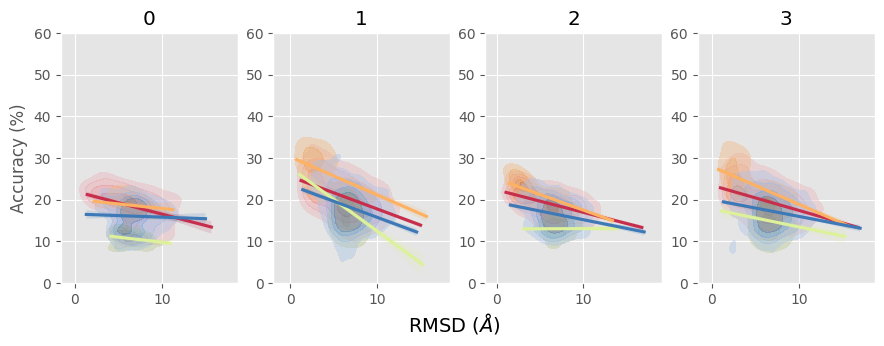

In [102]:
import matplotlib as mpl
from scipy.stats import pearsonr

from benchmark.config import classes
mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
pal = sns.color_palette("Spectral", n_colors=len(model_names))
new_palette = [pal[0], pal[3], pal[7], pal[-1]]
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)
axes = [ax, ax2, ax3, ax4]
class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
selected_x = "curr_rmsd"
selected_y = "seq_accuracy"
for i, curr_ax in enumerate(axes):
    if i < 3:
        sns.kdeplot(data=results_arr[(results_arr['temp']==1.0) & (results_arr['class']==i+1)], x=selected_x, y=selected_y, hue="model", legend=False, palette=new_palette, alpha=0.4, fill=True, thresh=0.15, levels=5, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==1.0) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")], x=selected_x, y=selected_y, scatter=False,line_kws={"color": new_palette[0]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==1.0) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")], x=selected_x, y=selected_y, scatter=False,line_kws={"color": new_palette[1]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==1.0) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")], x=selected_x, y=selected_y, scatter=False,line_kws={"color": new_palette[2]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==1.0) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")], x=selected_x, y=selected_y, scatter=False,line_kws={"color": new_palette[3]}, ax=curr_ax)        
        # Correlations:
        curr_x = results_arr[(results_arr['temp']==1.0) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")][selected_x]
        curr_y = results_arr[(results_arr['temp']==1.0) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")][selected_y]
        results_corr.append(["TIMED", i, 1.0, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==1.0) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==1.0) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")][selected_y]
        results_corr.append(["TIMED_Deep", i, 1.0, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==1.0) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")][selected_x]
        curr_y = results_arr[(results_arr['temp']==1.0) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")][selected_y]
        results_corr.append(["TIMED_Rotamer", i, 1.0, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==1.0) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==1.0) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_y]
        results_corr.append(["TIMED_Rotamer_Deep", i, 1.0, *pearsonr(curr_x,curr_y)])
    else:
        sns.kdeplot(data=results_arr[(results_arr['temp']==1.0)], x=selected_x, y=selected_y, hue="model", legend=False, palette=new_palette, alpha=0.4, fill=True, thresh=0.15, levels=5, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==1.0) & (results_arr['model']=="TIMED")], x=selected_x, y=selected_y, scatter=False,line_kws={"color": new_palette[0]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==1.0) & (results_arr['model']=="TIMED_Deep")], x=selected_x, y=selected_y, scatter=False,line_kws={"color": new_palette[1]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==1.0) & (results_arr['model']=="TIMED_Rotamer")], x=selected_x, y=selected_y, scatter=False,line_kws={"color": new_palette[2]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==1.0) & (results_arr['model']=="TIMED_Rotamer_Deep")], x=selected_x, y=selected_y, scatter=False,line_kws={"color": new_palette[3]}, ax=curr_ax)
        # Correlations:
        curr_x = results_arr[(results_arr['temp']==1.0) & (results_arr['model']=="TIMED")][selected_x]
        curr_y = results_arr[(results_arr['temp']==1.0) & (results_arr['model']=="TIMED")][selected_y]
        results_corr.append(["TIMED", i, 1.0, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==1.0) & (results_arr['model']=="TIMED_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==1.0) & (results_arr['model']=="TIMED_Deep")][selected_y]
        results_corr.append(["TIMED_Deep", i, 1.0, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==1.0) & (results_arr['model']=="TIMED_Rotamer")][selected_x]
        curr_y = results_arr[(results_arr['temp']==1.0) & (results_arr['model']=="TIMED_Rotamer")][selected_y]
        results_corr.append(["TIMED_Rotamer", i, 1.0, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==1.0) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==1.0) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_y]
        results_corr.append(["TIMED_Rotamer_Deep", i, 1.0, *pearsonr(curr_x,curr_y)])
    curr_ax.set_title(class_names[i])

    #curr_ax.set_xlim(0, 7.5)
    curr_ax.set_ylim(0, 60)
    if i==0:
        curr_ax.set_ylabel("Accuracy (%)")
    else:
        curr_ax.set_ylabel("")
    curr_ax.set_xlabel("")
    
    # Calculate correlations:
    #     curr_ax.axes.xaxis.set_visible(False)
    # curr_ax.axes.yaxis.set_visible(False)

    
    
# fig.add_subplot(111, frameon=False)
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
fig.text(0.5, -0.04, r"RMSD ($\AA$)", ha='center', fontsize=14)
# fig.subplots_adjust(wspace=0.05, hspace=0.3)

#plt.show()

In [103]:
pearson_df = pd.DataFrame(results_corr,columns=['model', 'fold', 'temp', 'pearson', 'p-value'])
pearson_df

,model,fold,temp,pearson,p-value
0,TIMED,0,0.2,-0.595841,2.525174e-39
1,TIMED_Deep,0,0.2,-0.797694,2.579258e-66
2,TIMED_Rotamer,0,0.2,-0.272103,3.544585e-02
3,TIMED_Rotamer_Deep,0,0.2,-0.503951,7.868857e-27
4,TIMED,1,0.2,-0.124207,6.849630e-11
5,TIMED_Deep,1,0.2,-0.129635,3.255629e-08
6,TIMED_Rotamer,1,0.2,-0.127512,5.259950e-05
7,TIMED_Rotamer_Deep,1,0.2,-0.153162,2.881680e-16
8,TIMED,2,0.2,-0.481453,2.790763e-116
9,TIMED_Deep,2,0.2,-0.264179,1.979272e-17


#### Accuracy vs RMSD correlation at different temperatures

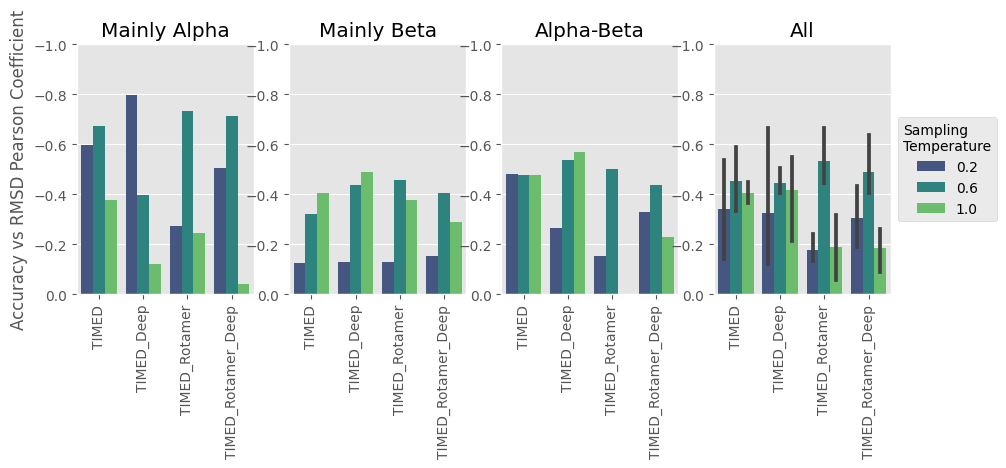

In [128]:
import matplotlib as mpl
from scipy.stats import pearsonr

from benchmark.config import classes
mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
pal = sns.color_palette("Spectral", n_colors=len(model_names))
new_palette = [pal[0], pal[3], pal[7], pal[-1]]
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)
axes = [ax, ax2, ax3, ax4]
class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
selected_x = "curr_rmsd"
selected_y = "seq_accuracy"
for i, curr_ax in enumerate(axes):
    if i < 3:
        sns.barplot(data=pearson_df[pearson_df['fold']==i], x="model", y="pearson", hue="temp", palette="viridis", ax=curr_ax)
        curr_ax.legend_.remove()
    else:
        sns.barplot(data=pearson_df, x="model", y="pearson", hue="temp", palette="viridis", ax=curr_ax)
        curr_ax.legend(title='Sampling\nTemperature', loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
        # Correlations:

    curr_ax.set_title(class_names[i])

    curr_ax.set_ylim(0, -1)
    if i==0:
        curr_ax.set_ylabel("Accuracy vs RMSD Pearson Coefficient")
    else:
        curr_ax.set_ylabel("")
    curr_ax.set_xlabel("")
    curr_ax.set_xticklabels(curr_ax.get_xticklabels(),rotation=90,)
    
    
    # Calculate correlations:
    #     curr_ax.axes.xaxis.set_visible(False)
    # curr_ax.axes.yaxis.set_visible(False)

    
    
# fig.add_subplot(111, frameon=False)
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# fig.subplots_adjust(wspace=0.05, hspace=0.3)

#plt.show()


#sns.barplot(data=pearson_df[pearson_df['fold']==0], x="model", y="pearson", hue="temp")


### Entropy vs RMSD

In [175]:
results_arr[(results_arr['temp']==0.2) & (results_arr['class']==1) & (results_arr['model']=='TIMED') ].groupby('pdb').mean()

,n,temp,seq_accuracy,curr_entropy_mean,curr_entropy_std,curr_packdensity_mean,curr_packdensity_std,real_packdensity_mean,real_packdensity_std,curr_bfactor_mean,curr_bfactor_std,curr_rmsd,class
pdb,,,,,,,,,,,,,
1a41A,10.0,0.2,24.482020,3.932107,0.496808,60.582895,11.409804,60.153281,11.625747,80.991683,9.203062,2.913859,1.0
1dvoA,9.5,0.2,37.269737,3.797704,0.685363,57.372434,9.095060,62.264803,9.892732,91.021133,4.864580,1.730742,1.0
1gxmA,9.5,0.2,37.731481,3.696182,0.786810,63.080656,12.280862,70.245370,12.220907,88.338384,9.340874,1.711042,1.0
1h32A,9.5,0.2,32.681992,3.568738,1.022330,62.065053,11.847820,71.750000,10.425117,91.239930,8.079230,1.331775,1.0


In [167]:
results_arr[(results_arr['temp']==0.2) & (results_arr['class']==3) & (results_arr['model']=='TIMED') ].groupby('pdb').mean()

,n,temp,seq_accuracy,curr_entropy_mean,curr_entropy_std,curr_packdensity_mean,curr_packdensity_std,real_packdensity_mean,real_packdensity_std,curr_bfactor_mean,curr_bfactor_std,curr_rmsd,class
pdb,,,,,,,,,,,,,
1b77A,9.5,0.2,29.736842,3.795664,0.672043,59.519967,12.097202,62.366776,10.940040,89.517711,6.197909,1.646709,3.0
1chdA,9.5,0.2,32.828283,3.691766,0.854781,59.318176,11.945804,64.369318,11.235887,80.589844,13.428156,2.072516,3.0
1dmlA,9.5,0.2,30.786517,3.773809,0.787961,59.152331,12.951985,59.614232,12.481543,78.491354,9.896764,2.531011,3.0
1ds1A,9.5,0.2,37.476780,3.690801,0.792201,61.040813,11.767761,66.320046,11.658028,89.264170,9.248244,1.299500,3.0
1ejdA,9.5,0.2,41.682578,3.571944,0.963070,60.159212,10.531151,66.789379,9.765777,89.150893,10.477120,1.664454,3.0
1ewfA,9.5,0.2,31.414474,3.761759,0.774982,60.588775,11.750875,63.801535,11.231656,87.498845,7.436307,3.099880,3.0
1g61A,9.5,0.2,41.822222,3.560996,0.900330,62.349150,10.663899,69.420000,8.180999,95.647148,3.334132,0.760857,3.0
1h70A,9.5,0.2,34.862745,3.707420,0.731650,60.412064,11.117658,64.187745,11.434800,88.954685,6.721533,1.535829,3.0
1hq0A,9.5,0.2,36.372881,3.651237,0.914351,62.876322,12.783085,65.350847,12.928826,88.022235,9.332515,1.651684,3.0


In [166]:
results_arr[(results_arr['temp']==0.2) & (results_arr['class']==2) & (results_arr['model']=='TIMED') ].groupby('pdb').mean()

,n,temp,seq_accuracy,curr_entropy_mean,curr_entropy_std,curr_packdensity_mean,curr_packdensity_std,real_packdensity_mean,real_packdensity_std,curr_bfactor_mean,curr_bfactor_std,curr_rmsd,class
pdb,,,,,,,,,,,,,
1b2pA,9.5,0.2,29.369748,3.686873,0.760758,55.293561,13.780935,66.403361,11.840418,66.546813,12.766564,3.016430,2.0
1b8kA,9.5,0.2,26.166667,3.750905,0.855689,49.716861,11.816029,55.738889,12.718133,58.680052,9.052641,4.575382,2.0
1bx7A,9.5,0.2,49.019608,3.018362,1.465980,46.570172,13.185066,49.982843,12.118113,78.569735,9.583296,2.123245,2.0
1c3mA,9.5,0.2,41.241379,3.419023,1.207909,60.120190,13.676105,61.526724,13.761141,92.815360,7.791290,1.340328,2.0
1cruA,9.5,0.2,37.209821,3.625772,0.895200,63.273359,13.308834,69.165737,13.335423,90.049759,7.234684,1.294661,2.0
1dqgA,9.5,0.2,35.111940,3.663910,0.840007,61.706894,14.825128,62.215485,14.357699,82.445128,10.444192,1.358264,2.0
1flgA,9.5,0.2,34.613402,3.672109,0.858193,65.082234,13.343087,64.830326,12.846446,85.545362,8.721307,1.579342,2.0
1g3pA,9.5,0.2,41.562500,3.525587,1.005590,55.584219,14.237991,65.966797,13.327717,67.305681,17.939669,5.101178,2.0
1genA,9.5,0.2,28.950000,3.745350,0.753623,58.862856,12.912342,63.223125,14.654425,83.371724,9.761484,2.027664,2.0


In [170]:
results_arr[(results_arr['temp']==0.2) & (results_arr['class']==1) & (results_arr['model']=='TIMED') ].groupby('pdb').mean()

,n,temp,seq_accuracy,curr_entropy_mean,curr_entropy_std,curr_packdensity_mean,curr_packdensity_std,real_packdensity_mean,real_packdensity_std,curr_bfactor_mean,curr_bfactor_std,curr_rmsd,class
pdb,,,,,,,,,,,,,
1a41A,10.0,0.2,24.482020,3.932107,0.496808,60.582895,11.409804,60.153281,11.625747,80.991683,9.203062,2.913859,1.0
1dvoA,9.5,0.2,37.269737,3.797704,0.685363,57.372434,9.095060,62.264803,9.892732,91.021133,4.864580,1.730742,1.0
1gxmA,9.5,0.2,37.731481,3.696182,0.786810,63.080656,12.280862,70.245370,12.220907,88.338384,9.340874,1.711042,1.0
1h32A,9.5,0.2,32.681992,3.568738,1.022330,62.065053,11.847820,71.750000,10.425117,91.239930,8.079230,1.331775,1.0


In [172]:
results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1)].groupby(['model','pdb']).mean()

n  temp  seq_accuracy  curr_entropy_mean  \
model              pdb                                                       
TIMED              1a41A  10.000000   0.2     24.482020           3.932107   
                   1dvoA   9.500000   0.2     37.269737           3.797704   
                   1gxmA   9.500000   0.2     37.731481           3.696182   
                   1h32A   9.500000   0.2     32.681992           3.568738   
TIMED_Deep         1a41A  10.000000   0.2     24.839247           3.825517   
                   1gxmA   9.500000   0.2     42.716049           3.510478   
                   1h32A   9.500000   0.2     40.900383           3.460131   
TIMED_Rotamer      1a41A  12.333333   0.2     27.413273           7.693652   
TIMED_Rotamer_Deep 1a41A  10.000000   0.2     25.196475           7.599647   
                   1dvoA   9.500000   0.2     40.164474           7.416673   
                   1gxmA   9.500000   0.2     45.462963           7.118610   
                   1h32A   9.500000   0.2     46.781609           7.086000   

                          curr_entropy_std  curr_packdensity_mean  \
model              pdb                                              
TIMED              1a41A          0.496808              60.582895   
                   1dvoA          0.685363              57.372434   
                   1gxmA          0.786810              63.080656   
                   1h32A          1.022330              62.065053   
TIMED_Deep         1a41A          0.567404              61.821839   
                   1gxmA          0.931272              63.685926   
                   1h32A          1.108047              62.370144   
TIMED_Rotamer      1a41A          0.570011              57.634908   
TIMED_Rotamer_Deep 1a41A          0.823634              57.376387   
                   1dvoA          1.182971              53.202944   
                   1gxmA          1.586879              60.568696   
                   1h32A          1.703922              59.153190   

                          curr_packdensity_std  real_packdensity_mean  \
model              pdb                                                  
TIMED              1a41A             11.409804              60.153281   
                   1dvoA              9.095060              62.264803   
                   1gxmA             12.280862              70.245370   
                   1h32A             11.847820              71.750000   
TIMED_Deep         1a41A             11.045961              60.153281   
                   1gxmA             12.364745              70.245370   
                   1h32A             11.713513              71.750000   
TIMED_Rotamer      1a41A             11.473265              60.153281   
TIMED_Rotamer_Deep 1a41A             11.144154              60.153281   
                   1dvoA              9.739864              62.264803   
                   1gxmA             12.611167              70.245370   
                   1h32A             11.617751              71.750000   

                          real_packdensity_std  curr_bfactor_mean  \
model              pdb                                              
TIMED              1a41A             11.625747          80.991683   
                   1dvoA              9.892732          91.021133   
                   1gxmA             12.220907          88.338384   
                   1h32A             10.425117          91.239930   
TIMED_Deep         1a41A             11.625747          84.043781   
                   1gxmA             12.220907          89.390017   
                   1h32A             10.425117          93.404114   
TIMED_Rotamer      1a41A             11.625747          81.489238   
TIMED_Rotamer_Deep 1a41A             11.625747          79.773718   
                   1dvoA              9.892732          87.845332   
                   1gxmA             12.220907          91.185965   
                   1h32A             10.425117        

### Entropy RMSD

/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Text(0.5, -0.04, 'RMSD ($\\AA$)')

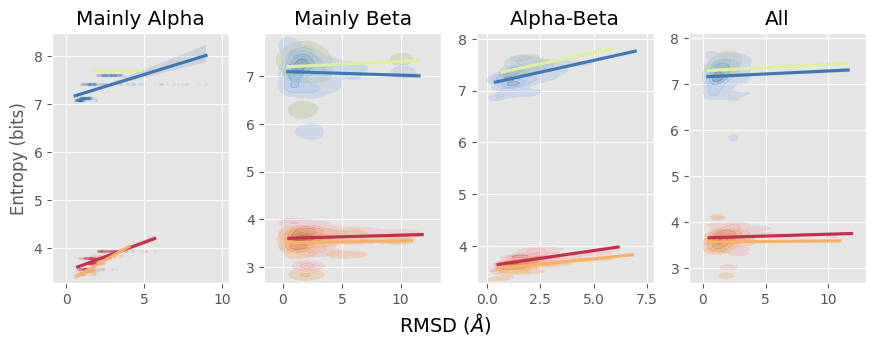

In [224]:
import matplotlib as mpl
from scipy.stats import pearsonr

from benchmark.config import classes
mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
pal = sns.color_palette("Spectral", n_colors=len(model_names))
new_palette = [pal[0], pal[3], pal[7], pal[-1]]
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)
axes = [ax, ax2, ax3, ax4]
results_corr = []
class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
selected_x = "curr_rmsd"
selected_y = "curr_entropy_mean"
for i, curr_ax in enumerate(axes):
    if i < 3:
        sns.kdeplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1)], x=selected_x, y=selected_y, hue="model", legend=False, palette=new_palette, alpha=0.4, fill=True, levels=5, ax=curr_ax)
        if i+1 == 1:
            scatter_mode = True
        else:
            scatter_mode = False
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[0], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[0]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[1], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[1]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[2], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[2]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[3], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[3]}, ax=curr_ax)        
        # Correlations:
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")][selected_y]
        results_corr.append([f"TIMED", i, 0.2, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")][selected_y]
        results_corr.append([f"TIMED_Deep", i, 0.2, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")][selected_y]
        results_corr.append([f"TIMED_Rotamer", i, 0.2, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_y]
        results_corr.append([f"TIMED_Rotamer_Deep", i, 0.2, *pearsonr(curr_x,curr_y)])
    else:
        sns.kdeplot(data=results_arr[(results_arr['temp']==0.2)], x=selected_x, y=selected_y, hue="model", legend=False, palette=new_palette, alpha=0.4, fill=True, thresh=0.15, levels=5, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[0], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[0]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Deep")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[1], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[1]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Rotamer")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[2], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[2]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Rotamer_Deep")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[3], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[3]}, ax=curr_ax)
        # Correlations:
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED")][selected_y]
        results_corr.append([f"TIMED", i, 0.2, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Deep")][selected_y]
        results_corr.append([f"TIMED_Deep", i, 0.2, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Rotamer")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Rotamer")][selected_y]
        results_corr.append([f"TIMED_Rotamer", i, 0.2, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_y]
        results_corr.append([f"TIMED_Rotamer_Deep", i, 0.2, *pearsonr(curr_x,curr_y)])
    curr_ax.set_title(class_names[i])

    #curr_ax.set_ylim(0, 60)
    if i==0:
        curr_ax.set_ylabel("Entropy (bits)")
    else:
        curr_ax.set_ylabel("")
    curr_ax.set_xlabel("")
    
    # Calculate correlations:
    #     curr_ax.axes.xaxis.set_visible(False)
    # curr_ax.axes.yaxis.set_visible(False)

    
    
# fig.add_subplot(111, frameon=False)
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
fig.text(0.5, -0.04, r"RMSD ($\AA$)", ha='center', fontsize=14)
# fig.subplots_adjust(wspace=0.05, hspace=0.3)

#plt.show()

In [182]:
results_arr[(results_arr['temp']==0.2) & (results_arr['class']==1)][selected_x]

35481    2.916642
35465    2.901474
35487    1.681721
35510    1.193448
35500    2.167086
           ...   
10637    1.260858
10825    1.712024
10754    0.910218
10755    1.827181
10734    1.041201
Name: curr_rmsd, Length: 1145, dtype: float64

/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/seaborn/distributions.py:1188: UserWarning: No contour levels were found within the data range.
  **contour_kws,


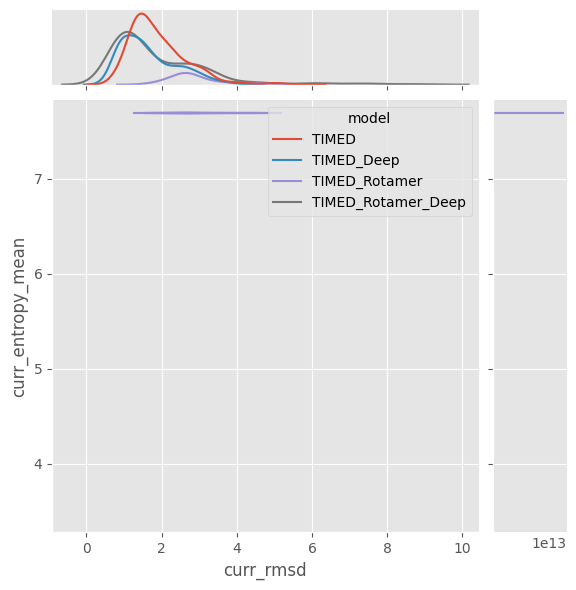

In [202]:
sns.jointplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==1)], x=selected_x, y=selected_y, hue="model", legend=True, kind='kde'  )

Text(0.5, -0.04, 'RMSD ($\\AA$)')

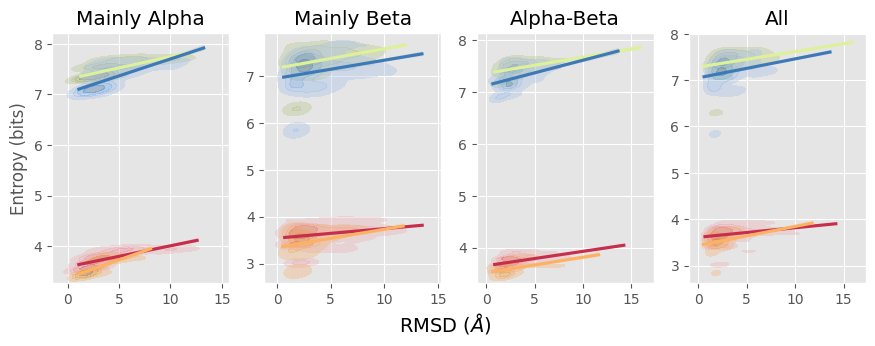

In [225]:
import matplotlib as mpl
from scipy.stats import pearsonr

from benchmark.config import classes
mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
pal = sns.color_palette("Spectral", n_colors=len(model_names))
new_palette = [pal[0], pal[3], pal[7], pal[-1]]
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)
axes = [ax, ax2, ax3, ax4]
class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
selected_x = "curr_rmsd"
selected_y = "curr_entropy_mean"
for i, curr_ax in enumerate(axes):
    if i < 3:
        sns.kdeplot(data=results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1)], x=selected_x, y=selected_y, hue="model", legend=False, palette=new_palette, alpha=0.4, fill=True, levels=5, ax=curr_ax)
        if i+1 == 1:
            scatter_mode = False
        else:
            scatter_mode = False
        sns.regplot(data=results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[0], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[0]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[1], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[1]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[2], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[2]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[3], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[3]}, ax=curr_ax)        
        # Correlations:
        curr_x = results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")][selected_y]
        results_corr.append([f"TIMED", i, 0.6, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")][selected_y]
        results_corr.append([f"TIMED_Deep", i, 0.6, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")][selected_y]
        results_corr.append([f"TIMED_Rotamer", i, 0.6, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_y]
        results_corr.append([f"TIMED_Rotamer_Deep", i, 0.6, *pearsonr(curr_x,curr_y)])
    else:
        sns.kdeplot(data=results_arr[(results_arr['temp']==0.6)], x=selected_x, y=selected_y, hue="model", legend=False, palette=new_palette, alpha=0.4, fill=True, thresh=0.15, levels=5, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[0], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[0]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED_Deep")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[1], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[1]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED_Rotamer")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[2], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[2]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED_Rotamer_Deep")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[3], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[3]}, ax=curr_ax)
        # Correlations:
        curr_x = results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED")][selected_y]
        results_corr.append([f"TIMED", i, 0.6, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED_Deep")][selected_y]
        results_corr.append([f"TIMED_Deep", i, 0.6, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED_Rotamer")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED_Rotamer")][selected_y]
        results_corr.append([f"TIMED_Rotamer", i, 0.6, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_y]
        results_corr.append([f"TIMED_Rotamer_Deep", i, 0.6, *pearsonr(curr_x,curr_y)])
    curr_ax.set_title(class_names[i])

    #curr_ax.set_ylim(0, 60)
    if i==0:
        curr_ax.set_ylabel("Entropy (bits)")
    else:
        curr_ax.set_ylabel("")
    curr_ax.set_xlabel("")
    
    # Calculate correlations:
    #     curr_ax.axes.xaxis.set_visible(False)
    # curr_ax.axes.yaxis.set_visible(False)

    
    
# fig.add_subplot(111, frameon=False)
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
fig.text(0.5, -0.04, r"RMSD ($\AA$)", ha='center', fontsize=14)
# fig.subplots_adjust(wspace=0.05, hspace=0.3)

#plt.show()

/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Text(0.5, -0.04, 'RMSD ($\\AA$)')

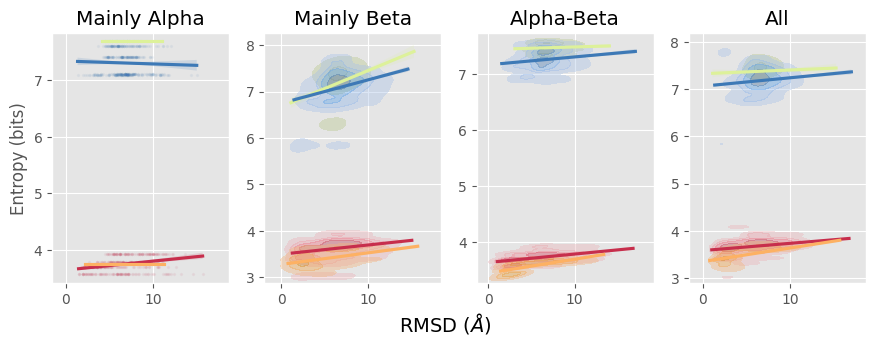

In [226]:
import matplotlib as mpl
from scipy.stats import pearsonr

from benchmark.config import classes
mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
pal = sns.color_palette("Spectral", n_colors=len(model_names))
new_palette = [pal[0], pal[3], pal[7], pal[-1]]
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)
axes = [ax, ax2, ax3, ax4]
class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
selected_x = "curr_rmsd"
selected_y = "curr_entropy_mean"
for i, curr_ax in enumerate(axes):
    if i < 3:
        sns.kdeplot(data=results_arr[(results_arr['temp']==1) & (results_arr['class']==i+1)], x=selected_x, y=selected_y, hue="model", legend=False, palette=new_palette, alpha=0.4, fill=True, levels=5, ax=curr_ax)
        if i+1 == 1:
            scatter_mode = True
        else:
            scatter_mode = False
        sns.regplot(data=results_arr[(results_arr['temp']==1) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[0], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[0]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==1) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[1], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[1]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==1) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[2], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[2]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==1) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[3], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[3]}, ax=curr_ax)        
        # Correlations:
        curr_x = results_arr[(results_arr['temp']==1) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")][selected_x]
        curr_y = results_arr[(results_arr['temp']==1) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")][selected_y]
        results_corr.append([f"TIMED", i, 1, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==1) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==1) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")][selected_y]
        results_corr.append([f"TIMED_Deep", i, 1, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==1) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")][selected_x]
        curr_y = results_arr[(results_arr['temp']==1) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")][selected_y]
        results_corr.append([f"TIMED_Rotamer", i, 1, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==1) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==1) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_y]
        results_corr.append([f"TIMED_Rotamer_Deep", i, 1, *pearsonr(curr_x,curr_y)])
    else:
        sns.kdeplot(data=results_arr[(results_arr['temp']==1)], x=selected_x, y=selected_y, hue="model", legend=False, palette=new_palette, alpha=0.4, fill=True, thresh=0.15, levels=5, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==1) & (results_arr['model']=="TIMED")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[0], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[0]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==1) & (results_arr['model']=="TIMED_Deep")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[1], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[1]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==1) & (results_arr['model']=="TIMED_Rotamer")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[2], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[2]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==1) & (results_arr['model']=="TIMED_Rotamer_Deep")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[3], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[3]}, ax=curr_ax)
        # Correlations:
        curr_x = results_arr[(results_arr['temp']==1) & (results_arr['model']=="TIMED")][selected_x]
        curr_y = results_arr[(results_arr['temp']==1) & (results_arr['model']=="TIMED")][selected_y]
        results_corr.append([f"TIMED", i, 1, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==1) & (results_arr['model']=="TIMED_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==1) & (results_arr['model']=="TIMED_Deep")][selected_y]
        results_corr.append([f"TIMED_Deep", i, 1, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==1) & (results_arr['model']=="TIMED_Rotamer")][selected_x]
        curr_y = results_arr[(results_arr['temp']==1) & (results_arr['model']=="TIMED_Rotamer")][selected_y]
        results_corr.append([f"TIMED_Rotamer", i, 1, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==1) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==1) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_y]
        results_corr.append([f"TIMED_Rotamer_Deep", i, 1, *pearsonr(curr_x,curr_y)])
    curr_ax.set_title(class_names[i])

    #curr_ax.set_ylim(0, 60)
    if i==0:
        curr_ax.set_ylabel("Entropy (bits)")
    else:
        curr_ax.set_ylabel("")
    curr_ax.set_xlabel("")
    
    # Calculate correlations:
    #     curr_ax.axes.xaxis.set_visible(False)
    # curr_ax.axes.yaxis.set_visible(False)

    
    
# fig.add_subplot(111, frameon=False)
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
fig.text(0.5, -0.04, r"RMSD ($\AA$)", ha='center', fontsize=14)
# fig.subplots_adjust(wspace=0.05, hspace=0.3)

#plt.show()

In [228]:
results_corr

[['TIMED', 0, 0.2, 0.6959656841797683, 1.719733529448981e-58],
 ['TIMED_Deep', 0, 0.2, 0.851923608245841, 2.6310743640043625e-84],
 ['TIMED_Rotamer', 0, 0.2, nan, nan],
 ['TIMED_Rotamer_Deep', 0, 0.2, 0.6292873846904661, 5.98889414484282e-45],
 ['TIMED', 1, 0.2, 0.07249567458777055, 0.00014583696384358341],
 ['TIMED_Deep', 1, 0.2, 0.040862928832528865, 0.0826353472039241],
 ['TIMED_Rotamer', 1, 0.2, 0.07372837244179815, 0.019713642186871067],
 ['TIMED_Rotamer_Deep', 1, 0.2, -0.041853676265232724, 0.026244648448770138],
 ['TIMED', 2, 0.2, 0.5722354830957379, 6.598320147357663e-174],
 ['TIMED_Deep', 2, 0.2, 0.4810329495447006, 4.844051304783304e-59],
 ['TIMED_Rotamer', 2, 0.2, 0.45927957766382194, 1.7030959820388614e-28],
 ['TIMED_Rotamer_Deep', 2, 0.2, 0.4781132934572362, 5.409731960123699e-119],
 ['TIMED', 3, 0.2, 0.07360505346230922, 9.876503554069037e-08],
 ['TIMED_Deep', 3, 0.2, 0.02081825090303044, 0.23906557760328848],
 ['TIMED_Rotamer', 3, 0.2, 0.07920124771512169, 0.001445510974

In [229]:
pearson_df = pd.DataFrame(results_corr,columns=['model', 'fold', 'temp', 'pearson', 'p-value'])
pearson_df

,model,fold,temp,pearson,p-value
0,TIMED,0,0.2,0.695966,1.719734e-58
1,TIMED_Deep,0,0.2,0.851924,2.631074e-84
2,TIMED_Rotamer,0,0.2,NaN,NaN
3,TIMED_Rotamer_Deep,0,0.2,0.629287,5.988894e-45
4,TIMED,1,0.2,0.072496,1.458370e-04
5,TIMED_Deep,1,0.2,0.040863,8.263535e-02
6,TIMED_Rotamer,1,0.2,0.073728,1.971364e-02
7,TIMED_Rotamer_Deep,1,0.2,-0.041854,2.624465e-02
8,TIMED,2,0.2,0.572235,6.598320e-174
9,TIMED_Deep,2,0.2,0.481033,4.844051e-59


/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


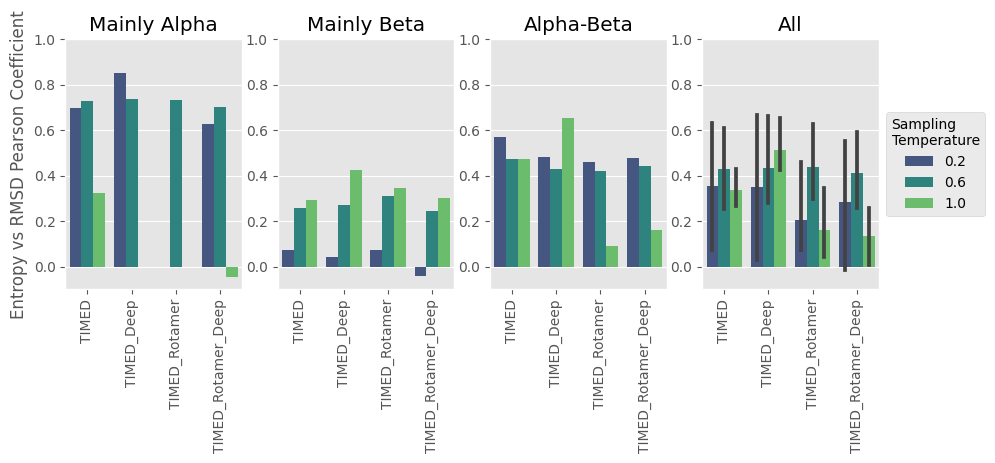

In [231]:
import matplotlib as mpl
from scipy.stats import pearsonr

from benchmark.config import classes
mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
pal = sns.color_palette("Spectral", n_colors=len(model_names))
new_palette = [pal[0], pal[3], pal[7], pal[-1]]
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)
axes = [ax, ax2, ax3, ax4]
class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
selected_x = "curr_rmsd"
selected_y = "curr_entropy_mean"
for i, curr_ax in enumerate(axes):
    if i < 3:
        sns.barplot(data=pearson_df[pearson_df['fold']==i], x="model", y="pearson", hue="temp", palette="viridis", ax=curr_ax)
        curr_ax.legend_.remove()
    else:
        sns.barplot(data=pearson_df, x="model", y="pearson", hue="temp", palette="viridis", ax=curr_ax)
        curr_ax.legend(title='Sampling\nTemperature', loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
        # Correlations:

    curr_ax.set_title(class_names[i])

    curr_ax.set_ylim(-0.1, 1)
    if i==0:
        curr_ax.set_ylabel("Entropy vs RMSD Pearson Coefficient")
    else:
        curr_ax.set_ylabel("")
    curr_ax.set_xlabel("")
    curr_ax.set_xticklabels(curr_ax.get_xticklabels(),rotation=90,)
    
    
    # Calculate correlations:
    #     curr_ax.axes.xaxis.set_visible(False)
    # curr_ax.axes.yaxis.set_visible(False)

    
    
# fig.add_subplot(111, frameon=False)
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# fig.subplots_adjust(wspace=0.05, hspace=0.3)

#plt.show()


#sns.barplot(data=pearson_df[pearson_df['fold']==0], x="model", y="pearson", hue="temp")


/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/seaborn/axisgrid.py:1826: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=self.x, y=self.y, **kwargs)
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/seaborn/distributions.py:1188: UserWarning: The following kwargs were not used by contour: 's', 'marker'
  **contour_kws,


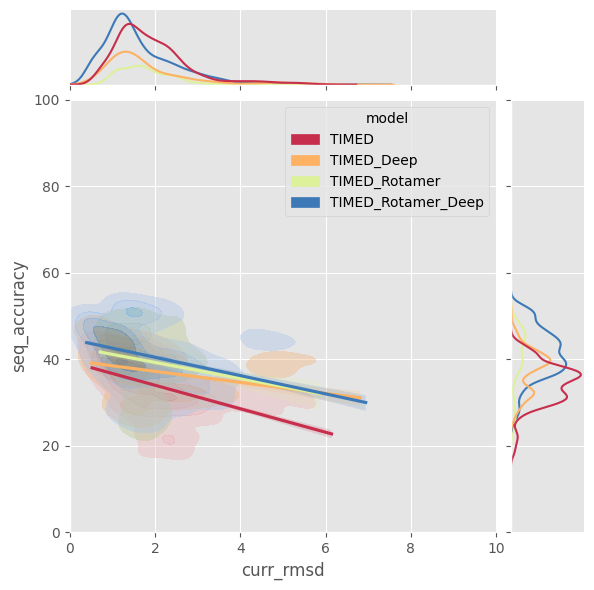

In [54]:
import matplotlib as mpl
from benchmark.config import classes
mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt
import seaborn as sns
pal = sns.color_palette("Spectral", n_colors=len(model_names))
new_palette = [pal[0], pal[3], pal[7], pal[-1]]
g = sns.jointplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==3)], x="curr_rmsd", y="seq_accuracy", hue="model",s=14, palette=new_palette, alpha=0.4, marker="+", n_levels=5,  kind="kde", shade=True, )
g.ax_marg_x.set_xlim(0, 10)
g.ax_marg_y.set_ylim(0, 100)
g1 = sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==3) & (results_arr['model']=="TIMED")], x="curr_rmsd", y="seq_accuracy", scatter=False,line_kws={"color": new_palette[0]}, ax=g.ax_joint, )
g2 = sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==3) & (results_arr['model']=="TIMED_Deep")], x="curr_rmsd", y="seq_accuracy", scatter=False,line_kws={"color": new_palette[1]}, ax=g.ax_joint)
g3 = sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==3) & (results_arr['model']=="TIMED_Rotamer")], x="curr_rmsd", y="seq_accuracy", scatter=False,line_kws={"color": new_palette[2]}, ax=g.ax_joint)
g4 = sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==3) & (results_arr['model']=="TIMED_Rotamer_Deep")], x="curr_rmsd", y="seq_accuracy", scatter=False,line_kws={"color": new_palette[3]}, ax=g.ax_joint)

In [ ]:
sns.color_palette("Spectral", n_colors=len(model_names))

In [154]:
pal = sns.color_palette("Spectral", n_colors=len(model_names))
new_palette = [pal[0], pal[3], pal[7], pal[-1]]

In [105]:
sns.color_palette("Spectral", n_colors=len(model_names))[1]

(0.8996539792387543, 0.340715109573241, 0.2848904267589389)

In [110]:
model_names[9]

'timed_rotamer_deep'

AttributeError: 'Line2D' object has no property 'edgecolor'

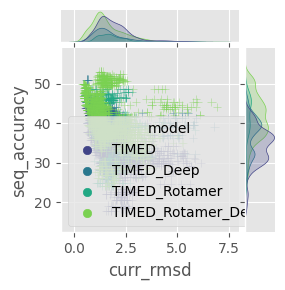

In [12]:
pal = sns.color_palette("viridis", n_colors=4)
g = sns.jointplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==3)], x="curr_rmsd", y="seq_accuracy", hue="model", palette="viridis", alpha=0.5, marker="+", height=3)
g1 = sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==3) & (results_arr['model']=="TIMED")], x="curr_rmsd", y="seq_accuracy", scatter=False,line_kws={"color": pal[0], "linewidth": 1, "edgecolor": "black"}, ax=g.ax_joint)
g2 = sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==3) & (results_arr['model']=="TIMED_Deep")], x="curr_rmsd", y="seq_accuracy", scatter=False,line_kws={"color": pal[1], "linewidth": 1, "edgecolor": "black"}, ax=g.ax_joint)
g3 = sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==3) & (results_arr['model']=="TIMED_Rotamer")], x="curr_rmsd", y="seq_accuracy", scatter=False,line_kws={"color": pal[2], "linewidth": 1, "edgecolor": "black"}, ax=g.ax_joint)
g4 = sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==3) & (results_arr['model']=="TIMED_Rotamer_Deep")], x="curr_rmsd", y="seq_accuracy", scatter=False,line_kws={"color": pal[3], "linewidth": 1, "edgecolor": "black"}, ax=g.ax_joint)
for ax in g.fig.axes:
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)

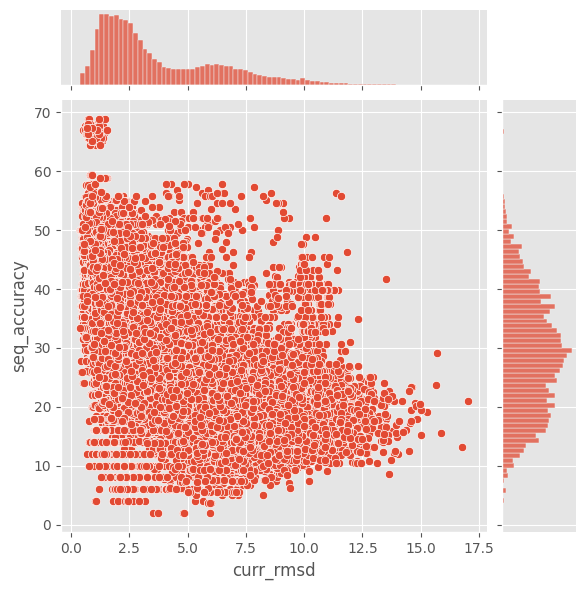

In [14]:
sns.jointplot(data=results_arr, x="curr_rmsd", y="seq_accuracy")

<AxesSubplot:xlabel='curr_rmsd', ylabel='seq_accuracy'>

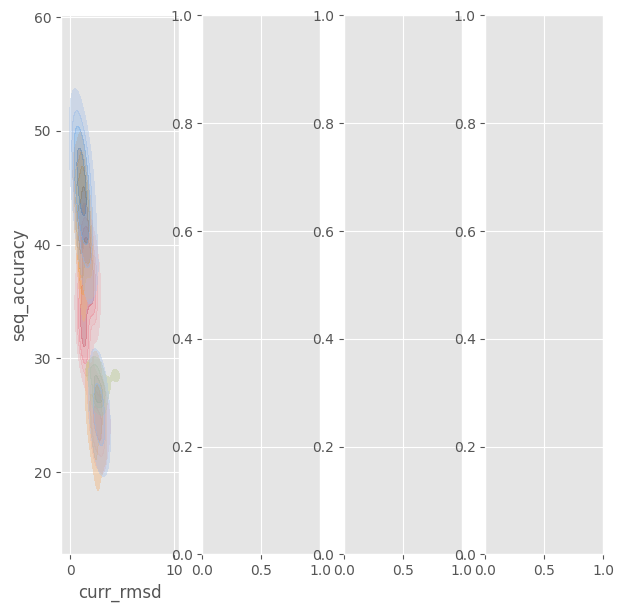

In [19]:
fig, (ax, ax2, ax3, ax4) = plt.subplots(ncols=4)
axes = [ax, ax2, ax3, ax4]
sns.kdeplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==1)], x="curr_rmsd", y="seq_accuracy", hue="model", legend=False, palette=new_palette, alpha=0.4, fill=True, thresh=0.15, levels=5, ax=ax)


In [58]:
results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")].curr_rmsd.to_numpy()

array([1.75642007, 1.02217069, 1.22703454, 1.21982202, 3.93461963,
       2.63767506, 1.29682701, 1.50199084, 0.96828726, 1.1682287 ,
       1.64450181, 4.29989087, 2.22250325, 1.49292751, 0.8822501 ,
       2.70334836, 2.5777452 , 1.14214803, 3.03248549, 2.26865698,
       1.11776607, 1.14140569, 1.48289455, 1.22419038, 1.3123061 ,
       1.25596892, 0.98053992, 1.28942861, 1.52149828, 1.53139387,
       1.11588777, 2.27018308, 2.95497644, 1.65678007, 1.05771441,
       1.12211582, 1.20887831, 0.96669299, 1.29980579, 2.1219798 ,
       3.11978117, 1.48335612, 2.73256976, 1.34180763, 1.26036499,
       0.94059777, 2.75225807, 0.98812667, 1.05246114, 1.68179632,
       2.22280478, 1.81905887, 2.8639531 , 1.21645447, 3.42762488,
       1.34953916, 2.31484975, 2.33186402, 5.23793919, 1.0468637 ,
       1.37741728, 1.14432695, 2.82388098, 1.4816087 , 1.16566882,
       1.23610545, 2.68558629, 2.62026134, 1.11132437, 1.56683641,
       1.35419236, 3.01784667, 0.95249158, 1.25719054, 1.24423

### Entropy vs AF2 confidence

/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Text(0.5, -0.04, 'AlphaFold2 IDDt')

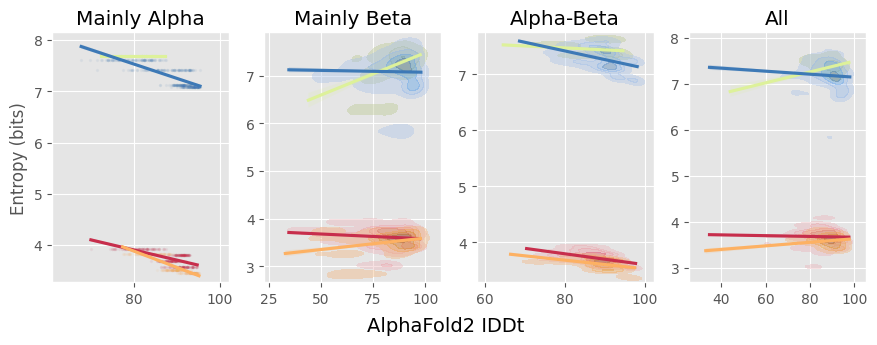

In [243]:
import matplotlib as mpl
from scipy.stats import pearsonr

from benchmark.config import classes
mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
pal = sns.color_palette("Spectral", n_colors=len(model_names))
new_palette = [pal[0], pal[3], pal[7], pal[-1]]
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)
axes = [ax, ax2, ax3, ax4]
results_corr = []
class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
selected_x = "curr_bfactor_mean"
selected_y = "curr_entropy_mean"
for i, curr_ax in enumerate(axes):
    if i < 3:
        sns.kdeplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1)], x=selected_x, y=selected_y, hue="model", legend=False, palette=new_palette, alpha=0.4, fill=True, levels=5, ax=curr_ax)
        if i+1 == 1:
            scatter_mode = True
        else:
            scatter_mode = False
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[0], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[0]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[1], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[1]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[2], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[2]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[3], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[3]}, ax=curr_ax)        
        # Correlations:
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")][selected_y]
        results_corr.append([f"TIMED", i, 0.2, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")][selected_y]
        results_corr.append([f"TIMED_Deep", i, 0.2, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")][selected_y]
        results_corr.append([f"TIMED_Rotamer", i, 0.2, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_y]
        results_corr.append([f"TIMED_Rotamer_Deep", i, 0.2, *pearsonr(curr_x,curr_y)])
    else:
        sns.kdeplot(data=results_arr[(results_arr['temp']==0.2)], x=selected_x, y=selected_y, hue="model", legend=False, palette=new_palette, alpha=0.4, fill=True, thresh=0.15, levels=5, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[0], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[0]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Deep")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[1], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[1]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Rotamer")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[2], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[2]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Rotamer_Deep")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[3], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[3]}, ax=curr_ax)
        # Correlations:
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED")][selected_y]
        results_corr.append([f"TIMED", i, 0.2, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Deep")][selected_y]
        results_corr.append([f"TIMED_Deep", i, 0.2, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Rotamer")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Rotamer")][selected_y]
        results_corr.append([f"TIMED_Rotamer", i, 0.2, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.2) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_y]
        results_corr.append([f"TIMED_Rotamer_Deep", i, 0.2, *pearsonr(curr_x,curr_y)])
    curr_ax.set_title(class_names[i])

    #curr_ax.set_ylim(0, 60)
    if i==0:
        curr_ax.set_ylabel("Entropy (bits)")
    else:
        curr_ax.set_ylabel("")
    curr_ax.set_xlabel("")
    
    # Calculate correlations:
    #     curr_ax.axes.xaxis.set_visible(False)
    # curr_ax.axes.yaxis.set_visible(False)

    
    
# fig.add_subplot(111, frameon=False)
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
fig.text(0.5, -0.04, r"AlphaFold2 IDDt", ha='center', fontsize=14)
# fig.subplots_adjust(wspace=0.05, hspace=0.3)

#plt.show()

Text(0.5, -0.04, 'AlphaFold2 IDDt')

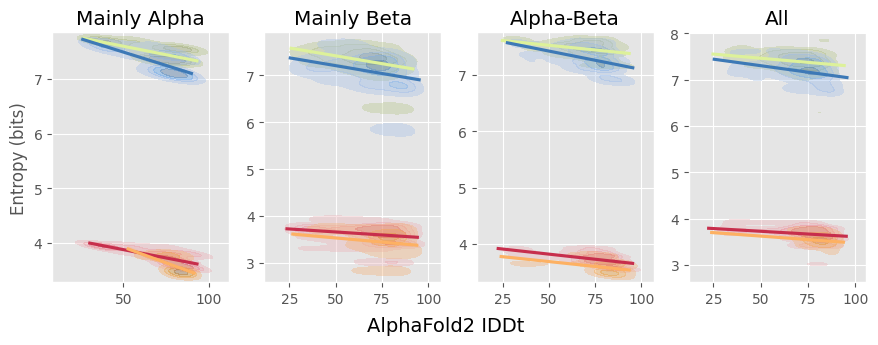

In [244]:
import matplotlib as mpl
from scipy.stats import pearsonr

from benchmark.config import classes
mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
pal = sns.color_palette("Spectral", n_colors=len(model_names))
new_palette = [pal[0], pal[3], pal[7], pal[-1]]
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)
axes = [ax, ax2, ax3, ax4]
class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
selected_x = "curr_bfactor_mean"
selected_y = "curr_entropy_mean"
for i, curr_ax in enumerate(axes):
    if i < 3:
        sns.kdeplot(data=results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1)], x=selected_x, y=selected_y, hue="model", legend=False, palette=new_palette, alpha=0.4, fill=True, levels=5, ax=curr_ax)
        if i+1 == 1:
            scatter_mode = False
        else:
            scatter_mode = False
        sns.regplot(data=results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[0], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[0]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[1], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[1]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[2], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[2]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[3], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[3]}, ax=curr_ax)        
        # Correlations:
        curr_x = results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")][selected_y]
        results_corr.append([f"TIMED", i, 0.6, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")][selected_y]
        results_corr.append([f"TIMED_Deep", i, 0.6, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")][selected_y]
        results_corr.append([f"TIMED_Rotamer", i, 0.6, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.6) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_y]
        results_corr.append([f"TIMED_Rotamer_Deep", i, 0.6, *pearsonr(curr_x,curr_y)])
    else:
        sns.kdeplot(data=results_arr[(results_arr['temp']==0.6)], x=selected_x, y=selected_y, hue="model", legend=False, palette=new_palette, alpha=0.4, fill=True, thresh=0.15, levels=5, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[0], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[0]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED_Deep")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[1], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[1]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED_Rotamer")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[2], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[2]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED_Rotamer_Deep")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[3], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[3]}, ax=curr_ax)
        # Correlations:
        curr_x = results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED")][selected_y]
        results_corr.append([f"TIMED", i, 0.6, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED_Deep")][selected_y]
        results_corr.append([f"TIMED_Deep", i, 0.6, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED_Rotamer")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED_Rotamer")][selected_y]
        results_corr.append([f"TIMED_Rotamer", i, 0.6, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==0.6) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_y]
        results_corr.append([f"TIMED_Rotamer_Deep", i, 0.6, *pearsonr(curr_x,curr_y)])
    curr_ax.set_title(class_names[i])

    #curr_ax.set_ylim(0, 60)
    if i==0:
        curr_ax.set_ylabel("Entropy (bits)")
    else:
        curr_ax.set_ylabel("")
    curr_ax.set_xlabel("")
    
    # Calculate correlations:
    #     curr_ax.axes.xaxis.set_visible(False)
    # curr_ax.axes.yaxis.set_visible(False)

    
    
# fig.add_subplot(111, frameon=False)
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
fig.text(0.5, -0.04, r"AlphaFold2 IDDt", ha='center', fontsize=14)
# fig.subplots_adjust(wspace=0.05, hspace=0.3)

#plt.show()

/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Text(0.5, -0.04, 'AlphaFold2 IDDt')

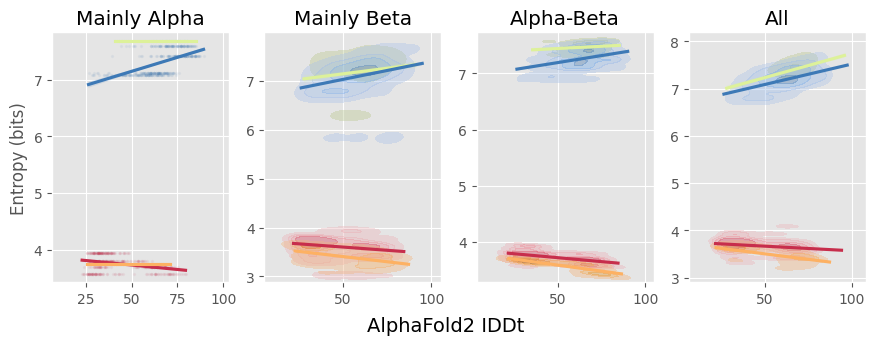

In [245]:
import matplotlib as mpl
from scipy.stats import pearsonr

from benchmark.config import classes
mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
pal = sns.color_palette("Spectral", n_colors=len(model_names))
new_palette = [pal[0], pal[3], pal[7], pal[-1]]
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)
axes = [ax, ax2, ax3, ax4]
class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
selected_x = "curr_bfactor_mean"
selected_y = "curr_entropy_mean"
for i, curr_ax in enumerate(axes):
    if i < 3:
        sns.kdeplot(data=results_arr[(results_arr['temp']==1.0) & (results_arr['class']==i+1)], x=selected_x, y=selected_y, hue="model", legend=False, palette=new_palette, alpha=0.4, fill=True, levels=5, ax=curr_ax)
        if i+1 == 1:
            scatter_mode = True
        else:
            scatter_mode = False
        sns.regplot(data=results_arr[(results_arr['temp']==1.0) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[0], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[0]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==1.0) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[1], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[1]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==1.0) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[2], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[2]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==1.0) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")], x=selected_x, y=selected_y, scatter=scatter_mode,scatter_kws={"color":  new_palette[3], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[3]}, ax=curr_ax)        
        # Correlations:
        curr_x = results_arr[(results_arr['temp']==1.0) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")][selected_x]
        curr_y = results_arr[(results_arr['temp']==1.0) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED")][selected_y]
        results_corr.append([f"TIMED", i, 1.0, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==1.0) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==1.0) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Deep")][selected_y]
        results_corr.append([f"TIMED_Deep", i, 1.0, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==1.0) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")][selected_x]
        curr_y = results_arr[(results_arr['temp']==1.0) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer")][selected_y]
        results_corr.append([f"TIMED_Rotamer", i, 1.0, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==1.0) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==1.0) & (results_arr['class']==i+1) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_y]
        results_corr.append([f"TIMED_Rotamer_Deep", i, 1.0, *pearsonr(curr_x,curr_y)])
    else:
        sns.kdeplot(data=results_arr[(results_arr['temp']==1.0)], x=selected_x, y=selected_y, hue="model", legend=False, palette=new_palette, alpha=0.4, fill=True, thresh=0.15, levels=5, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==1.0) & (results_arr['model']=="TIMED")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[0], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[0]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==1.0) & (results_arr['model']=="TIMED_Deep")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[1], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[1]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==1.0) & (results_arr['model']=="TIMED_Rotamer")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[2], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[2]}, ax=curr_ax)
        sns.regplot(data=results_arr[(results_arr['temp']==1.0) & (results_arr['model']=="TIMED_Rotamer_Deep")], x=selected_x, y=selected_y, scatter=False,scatter_kws={"color":  new_palette[3], 's':2, 'alpha': 0.05},line_kws={"color": new_palette[3]}, ax=curr_ax)
        # Correlations:
        curr_x = results_arr[(results_arr['temp']==1.0) & (results_arr['model']=="TIMED")][selected_x]
        curr_y = results_arr[(results_arr['temp']==1.0) & (results_arr['model']=="TIMED")][selected_y]
        results_corr.append([f"TIMED", i, 1.0, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==1.0) & (results_arr['model']=="TIMED_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==1.0) & (results_arr['model']=="TIMED_Deep")][selected_y]
        results_corr.append([f"TIMED_Deep", i, 1.0, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==1.0) & (results_arr['model']=="TIMED_Rotamer")][selected_x]
        curr_y = results_arr[(results_arr['temp']==1.0) & (results_arr['model']=="TIMED_Rotamer")][selected_y]
        results_corr.append([f"TIMED_Rotamer", i, 1.0, *pearsonr(curr_x,curr_y)])
        curr_x = results_arr[(results_arr['temp']==1.0) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_x]
        curr_y = results_arr[(results_arr['temp']==1.0) & (results_arr['model']=="TIMED_Rotamer_Deep")][selected_y]
        results_corr.append([f"TIMED_Rotamer_Deep", i, 1.0, *pearsonr(curr_x,curr_y)])
    curr_ax.set_title(class_names[i])

    #curr_ax.set_ylim(0, 60)
    if i==0:
        curr_ax.set_ylabel("Entropy (bits)")
    else:
        curr_ax.set_ylabel("")
    curr_ax.set_xlabel("")
    
    # Calculate correlations:
    #     curr_ax.axes.xaxis.set_visible(False)
    # curr_ax.axes.yaxis.set_visible(False)

    
    
# fig.add_subplot(111, frameon=False)
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
fig.text(0.5, -0.04, r"AlphaFold2 IDDt", ha='center', fontsize=14)
# fig.subplots_adjust(wspace=0.05, hspace=0.3)

#plt.show()

In [246]:
pearson_df = pd.DataFrame(results_corr,columns=['model', 'fold', 'temp', 'pearson', 'p-value'])
pearson_df

,model,fold,temp,pearson,p-value
0,TIMED,0,0.2,-0.688717,7.674844e-57
1,TIMED_Deep,0,0.2,-0.845830,6.018358e-82
2,TIMED_Rotamer,0,0.2,NaN,NaN
3,TIMED_Rotamer_Deep,0,0.2,-0.801351,9.975378e-90
4,TIMED,1,0.2,-0.119032,4.101542e-10
5,TIMED_Deep,1,0.2,0.283556,1.002818e-34
6,TIMED_Rotamer,1,0.2,0.442788,2.887374e-49
7,TIMED_Rotamer_Deep,1,0.2,-0.023813,2.061720e-01
8,TIMED,2,0.2,-0.483338,2.621076e-117
9,TIMED_Deep,2,0.2,-0.417692,1.697911e-43


/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/s1622572/anaconda3/envs/pdbcompare/lib/python3.7/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


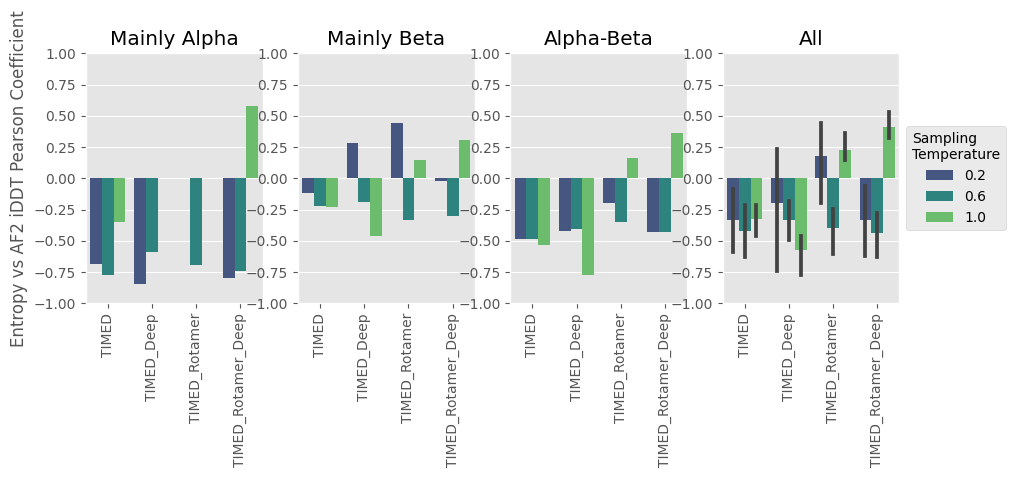

In [251]:
import matplotlib as mpl
from scipy.stats import pearsonr

from benchmark.config import classes
mpl.rc("savefig", dpi=300)
nice_fonts = {
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Times New Roman",
}
mpl.rcParams.update(nice_fonts)
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
pal = sns.color_palette("Spectral", n_colors=len(model_names))
new_palette = [pal[0], pal[3], pal[7], pal[-1]]
fig, (ax, ax2, ax3, ax4) = plt.subplots(figsize=set_size(505.89*1.5), ncols=4)
axes = [ax, ax2, ax3, ax4]
class_names = ["Mainly Alpha", "Mainly Beta", "Alpha-Beta", "All"]
selected_x = "curr_bfactor_mean"
selected_y = "curr_entropy_mean"
for i, curr_ax in enumerate(axes):
    if i < 3:
        sns.barplot(data=pearson_df[pearson_df['fold']==i], x="model", y="pearson", hue="temp", palette="viridis", ax=curr_ax)
        curr_ax.legend_.remove()
    else:
        sns.barplot(data=pearson_df, x="model", y="pearson", hue="temp", palette="viridis", ax=curr_ax)
        curr_ax.legend(title='Sampling\nTemperature', loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
        # Correlations:

    curr_ax.set_title(class_names[i])

    curr_ax.set_ylim(-1, 1)
    if i==0:
        curr_ax.set_ylabel("Entropy vs AF2 iDDT Pearson Coefficient")
    else:
        curr_ax.set_ylabel("")
    curr_ax.set_xlabel("")
    curr_ax.set_xticklabels(curr_ax.get_xticklabels(),rotation=90,)
    
    
    # Calculate correlations:
    #     curr_ax.axes.xaxis.set_visible(False)
    # curr_ax.axes.yaxis.set_visible(False)

    
    
# fig.add_subplot(111, frameon=False)
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# fig.subplots_adjust(wspace=0.05, hspace=0.3)

#plt.show()


#sns.barplot(data=pearson_df[pearson_df['fold']==0], x="model", y="pearson", hue="temp")
